## Read Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import RegularGridInterpolator
path_to_data = "/home/jli159/blf/labeled_trace_climate_change_icwsm23.feather"
output_name = "/home/jli159/blf/labeled_trace_climate_change_icwsm23_v.feather"

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: NVIDIA RTX A6000


## Vector Field

In [4]:
def derive_transition_grid(data,grid_size):
    df = trace[["u_id","x","y","dt"]]

    df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
    df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

    # Sort by user and datetime to ensure correct transition order
    df.sort_values(['u_id', 'dt'], inplace=True)

    # Calculate transitions
    df['from_x'] = df['x_grid'].shift(1)
    df['from_y'] = df['y_grid'].shift(1)
    df['to_x'] = df['x_grid']
    df['to_y'] = df['y_grid']

    # Filter out rows that do not represent a transition (first occurrence for each user)
    transitions = df[df['u_id'] == df['u_id'].shift(1)]

    transitions['dx'] = transitions['to_x'] - transitions['from_x']
    transitions['dy'] = transitions['to_y'] - transitions['from_y']
    tx = transitions[['from_x','from_y','dx','dy']]
    return tx
    
# Underlying grid size
grid_size = 100
trace = pd.read_feather(path_to_data)
tx = derive_transition_grid(trace,grid_size)

/tmp/ipykernel_4086865/2151132602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
/tmp/ipykernel_4086865/2151132602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)
/tmp/ipykernel_4086865/2151132602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

## Bayesian smoothing

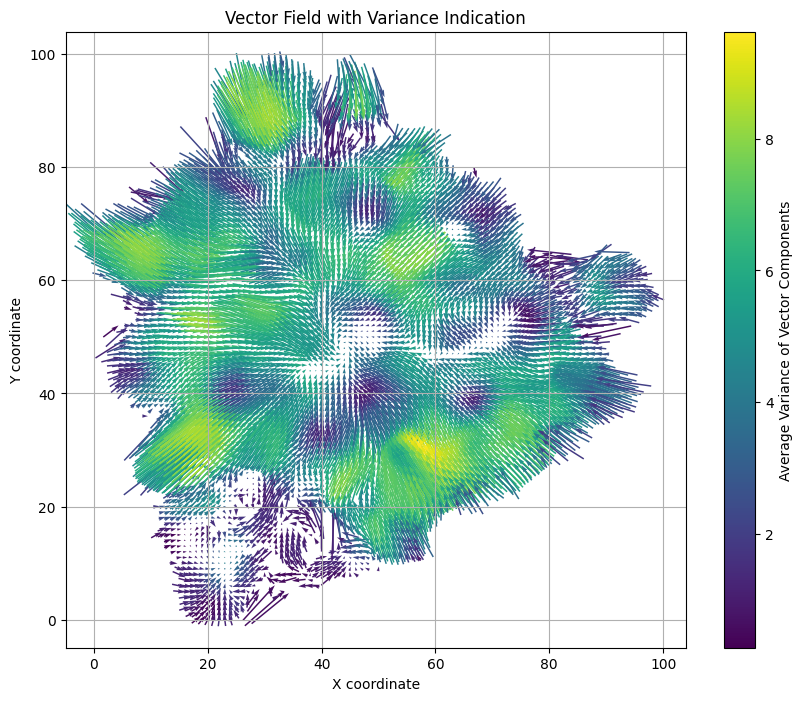

In [5]:
import numpy as np

# Utiliity functions to convert between dataframes and grids

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            
            x_coord = i if x_grid is None else x_grid[i,j]
            y_coord = j if y_grid is None else y_grid[i,j]
            row = {
                'from_x': x_coord,
                'from_y': y_coord,
                'mu_dx': mu_dx_grid[i, j],
                'mu_dy': mu_dy_grid[i, j]}
            if var_dx_grid is not None and var_dy_grid is not None:
                row['var_dx']=var_dx_grid[i, j]
                row['var_dy'] = var_dy_grid[i, j]
            data.append(row)

    return pd.DataFrame(data)

# Bayesian updating

def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        #var_sample = (var_prior + epsilon) / 2
        var_sample = np.max([var_prior, var_sample])  # Use maximum variance for single samples
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    #precision_sample = 1 / var_sample
    precision_sample = count / var_sample  # Scale precision by count
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior


def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

# Spatial smoothing

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1]: #and (di != 0 or dj != 0):
                #weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme:
                if np.isnan(mu_grid[ni, nj]):
                    continue
                dist = np.sqrt(di**2 + dj**2)# + 1e-10
                weight = 1 / (1+dist) if dist > 0 else 1.0
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Plotting for inspection
import matplotlib.pyplot as plt

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()


def plot_speed_map(df):
    # Calculate the speed (magnitude of velocity vector)
    df['avg_mu'] = np.sqrt(df['mu_dx']**2 + df['mu_dy']**2)
    
    # Get unique x and y coordinates in sorted order
    x_unique = np.sort(df['from_x'].unique())
    y_unique = np.sort(df['from_y'].unique())
    
    # Create a meshgrid for proper orientation
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create the speed grid
    speed_grid = np.zeros((len(y_unique), len(x_unique)))
    for i, x in enumerate(x_unique):
        for j, y in enumerate(y_unique):
            mask = (df['from_x'] == x) & (df['from_y'] == y)
            if any(mask):
                speed_grid[j, i] = df.loc[mask, 'avg_mu'].iloc[0]
    
    # Plotting the speed map
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.pcolormesh(X, Y, speed_grid, cmap='viridis')
    
    # Adding a color bar
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Speed (Magnitude of Vector)')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Speed Map')
    plt.grid(True)
    plt.show()

smoothed = process_df(tx, 0,1)
mu_dx,mu_dy,var_dx,var_dy = dataframe_to_grid(smoothed)
mu_dx,mu_dy,var_dx,var_dy = apply_spatial_smoothing(mu_dx,mu_dy,var_dx,var_dy,2)
averaged = grid_to_dataframe(mu_dx,mu_dy,var_dx_grid=var_dx,var_dy_grid=var_dy)
plot_vector_field_with_var(averaged,.7)

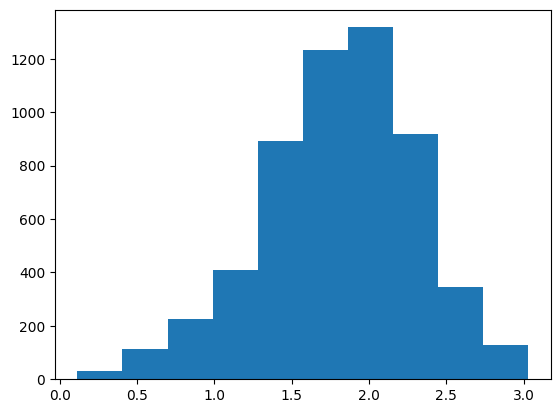

In [6]:
import matplotlib.pyplot as plt
avg_mu = np.sqrt(averaged['mu_dx']**2 + averaged['mu_dy']**2)
plt.hist(np.log1p(avg_mu))
plt.show()
#plot_speed_map(averaged)

## Vector Field Adjustment

In [7]:
def plot_density_map(df):
    x_unique = np.sort(df['from_x'].unique())
    y_unique = np.sort(df['from_y'].unique())
    
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create density grid
    density_grid = np.zeros((len(y_unique), len(x_unique)))
    for i, x in enumerate(x_unique):
        for j, y in enumerate(y_unique):
            mask = (df['from_x'] == x) & (df['from_y'] == y)
            if any(mask):
                density_grid[j, i] = df.loc[mask, 'norm_density'].iloc[0]
    
    # Plotting the density map
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.pcolormesh(X, Y, density_grid, cmap='plasma')
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Normalized Density')
    
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Density Map from KDE')
    plt.grid(True)
    plt.show()

In [8]:
"""
Physics-Based Vector Field Adjustment using Fluid Dynamics Principles
====================================================================

This module implements a theoretically-grounded approach to vector field modification
based on density distributions, using established principles from fluid dynamics, 
potential flow theory, and continuum mechanics.

The algorithm models the dense regions as permeable obstacles in a fluid flow field,
applying a rigorous mathematical framework derived from the Navier-Stokes equations
for incompressible flow through variable-density media.

Physical Basis and Governing Equations:
--------------------------------------
1. Momentum conservation (derived from Navier-Stokes):
   ρ(∂v/∂t + v·∇v) = -∇p + μ∇²v + ρg
   
   For steady-state flow in permeable media, this simplifies to:
   v·∇v = -∇p/ρ + ν∇²v + g - (μ/κ)v
   
   where the last term represents Darcy's resistance in porous media
   with κ as the permeability coefficient.

2. Mass conservation (continuity equation):
   ∇·(ρv) = 0
   
   For incompressible flow with variable density:
   v·∇ρ + ρ∇·v = 0

3. Advection-diffusion for density propagation:
   ∂ρ/∂t + v·∇ρ = D∇²ρ
   
   where D is the diffusion coefficient.

Implementation Approach:
----------------------
The algorithm implements a finite difference approximation of these equations
with a fractional step method:

1. Direction modification based on pressure gradient forces
2. Velocity adjustment based on permeability (Darcy's Law)
3. Flow acceleration effects (Venturi, Bernoulli)
4. Spatial coherence enforcement via vector field topology

Dimensionless Parameters:
-----------------------
1. Reynolds number (Re): Ratio of inertial to viscous forces
2. Froude number (Fr): Ratio of inertial to gravitational forces
3. Darcy number (Da): Ratio of permeability to characteristic length scale
4. Peclet number (Pe): Ratio of advection to diffusion

References:
----------
1. Batchelor, G.K. (2000). An Introduction to Fluid Dynamics
2. Bear, J. (1972). Dynamics of Fluids in Porous Media
3. Chorin, A.J. (1968). Numerical solution of the Navier-Stokes equations
4. Jobard, B. & Lefer, W. (1997). Creating Evenly-Spaced Streamlines of Arbitrary Density
"""
def apply_kde_to_vector_field(averaged, trace_df, x_col='x', y_col='y', bandwidth=None):
    # First, transform trace points to the same coordinate system as the vector field
    # Get min/max of original data
    x_min, x_max = trace_df[x_col].min(), trace_df[x_col].max()
    y_min, y_max = trace_df[y_col].min(), trace_df[y_col].max()
    
    # Get grid coordinates range
    grid_x_min, grid_x_max = averaged['from_x'].min(), averaged['from_x'].max()
    grid_y_min, grid_y_max = averaged['from_y'].min(), averaged['from_y'].max()
    
    # Create transformed points that map to the grid
    transformed_x = ((trace_df[x_col] - x_min) / (x_max - x_min) * 
                     (grid_x_max - grid_x_min) + grid_x_min)
    transformed_y = ((trace_df[y_col] - y_min) / (y_max - y_min) * 
                     (grid_y_max - grid_y_min) + grid_y_min)
    
    # Use transformed points for KDE
    import numpy as np
    from scipy.stats import gaussian_kde
    
    pts = np.vstack([transformed_x, transformed_y])
    
    if pts.shape[1] < 5:  # Not enough points for KDE
        print("Not enough trace points for KDE estimation.")
        return averaged
        
    # Build KDE from transformed trace points
    kde_obj = gaussian_kde(pts, bw_method=bandwidth)
    
    # Calculate density at each vector field point
    points_array = averaged[['from_x', 'from_y']].values.T
    averaged['density'] = kde_obj(points_array)
    
    # Normalize density values between 0 and 1
    min_dens = averaged['density'].min()
    max_dens = averaged['density'].max()
    averaged['norm_density'] = (averaged['density'] - min_dens) / (max_dens - min_dens + 1e-10)
    
    print(f"KDE applied to vector field. Density range: [{min_dens:.3e}, {max_dens:.3e}]")
    
    # Apply modifications to the vector field
    return adjust_vectors_by_density(averaged)

def adjust_vectors_by_density(df, physical_params=None, grid_step=2.0):
    """
    Adjust vector field based on density distribution using rigorous fluid dynamics principles.
    
    This function implements a physically-based model of fluid flow through variable density
    media, combining principles from potential flow theory, Darcy's Law for porous media,
    and the Navier-Stokes equations for incompressible flow.
    
    The mathematical framework is based on the following:
    1. The density field is treated as a pressure field influence
    2. Direction adjustment follows streamline deflection from pressure gradients
    3. Magnitude adjustment is calculated from Darcy's Law and continuity equation
    4. Field coherence is enforced through a multi-scale vector field smoothing
    
    Parameters:
    -----------
    df : The input vector field with coordinates ('from_x', 'from_y'), 
        vector components ('mu_dx', 'mu_dy'), and normalized density ('norm_density')
    physical_params : PhysicalParameters, default=None
        Parameters controlling the physical behavior of the vector field adjustment
    grid_step : float, default=2.0
        Spatial discretization parameter for gradient calculations
    
    Returns:
    --------
    pandas.DataFrame
        Modified vector field with physically accurate flow behavior
    
    Notes:
    ------
    The implementation uses finite difference approximations for spatial derivatives
    and applies a multi-scale smoothing approach to ensure field continuity.
    """
    # Initialize physical parameters with defaults if not provided
    if physical_params is None:
        physical_params = PhysicalParameters()
    
    # Compute dependent parameters based on grid step
    phys = physical_params.compute_dependent_parameters(grid_step)
    
    L_char     = phys["L_char"]
    Re_analog  = phys["Re_analog"]
    scale_factor = phys["scale_factor"]
    # Create mappings for faster lookup
    density_map = {(row['from_x'], row['from_y']): row['norm_density'] 
                   for _, row in df.iterrows()}
    vector_map = {(row['from_x'], row['from_y']): (row['mu_dx'], row['mu_dy']) 
                  for _, row in df.iterrows()}
    
    # Get unique x and y coordinates in the grid
    unique_x = sorted(df['from_x'].unique())
    unique_y = sorted(df['from_y'].unique())
    
    # Grid spacing parameters for spatial derivatives
    x_step = unique_x[1] - unique_x[0] if len(unique_x) > 1 else grid_step
    y_step = unique_y[1] - unique_y[0] if len(unique_y) > 1 else grid_step

    # Define a cosine-ramp sponge layer for the domain edge
    x_min_domain, x_max_domain = unique_x[0], unique_x[-1]
    y_min_domain, y_max_domain = unique_y[0], unique_y[-1]
    domain_span          = max(x_max_domain - x_min_domain, y_max_domain - y_min_domain)
    edge_buffer          = 0.10 * domain_span      # 10 % of the domain as a sponge layer
    cos_ramp = lambda s: 0.5 - 0.5*np.cos(np.pi*s) # smooth C¹ ramp 0→1

    # Scale factor from physical parameters
    scale_factor = phys['scale_factor']
    print(f"Using physical scale factor of {scale_factor:.3f} for grid_step = {grid_step}")
    
    # Initialize structures for vector field analysis
    result_rows = []
    all_gradients = []
    all_laplacians = []
    
    # Calculate characteristic density scale for Reynolds number approximation
    density_mean = np.mean(df['norm_density'].values)
    density_std = np.std(df['norm_density'].values)
    
    # Phase 1: Calculate density field metrics for each point using finite difference methods
    print("Phase 1: Calculating field metrics using finite difference approximations...")
    
    # Create field metrics storage
    field_metrics = {}
    
    for _, row in df.iterrows():
        x, y = row['from_x'], row['from_y']
        norm_density = row['norm_density']
        
        # Collect neighbors for differential calculations
        # Define stencil for finite difference approximations
        stencil = {
            "central": [(1, 0), (-1, 0), (0, 1), (0, -1)],  # Central difference stencil
            "wider": [(2, 0), (-2, 0), (0, 2), (0, -2)],     # Wider stencil for higher accuracy
            "diagonal": [(1, 1), (1, -1), (-1, 1), (-1, -1)]  # Diagonal points for Laplacian
        }
        
        # Collect density values at stencil points
        density_stencil = {}
        
        for stencil_type, offsets in stencil.items():
            density_stencil[stencil_type] = {}
            for dx, dy in offsets:
                nx, ny = x + dx * x_step, y + dy * y_step
                if (nx, ny) in density_map:
                    density_stencil[stencil_type][(dx, dy)] = density_map[(nx, ny)]
        
        # Calculate first derivatives (gradient) using central difference
        # ∇ρ = (∂ρ/∂x, ∂ρ/∂y)
        grad_x, grad_y = 0, 0
        gradient_order = "central"  # Default to central difference
        
        # Attempt central difference approximation (most accurate)
        if (1, 0) in density_stencil["central"] and (-1, 0) in density_stencil["central"]:
            # Central difference: (f(x+h) - f(x-h)) / 2h
            grad_x = (density_stencil["central"][(1, 0)] - density_stencil["central"][(-1, 0)]) / (2 * x_step)
        # Fall back to forward/backward differences if needed
        elif (1, 0) in density_stencil["central"]:
            # Forward difference: (f(x+h) - f(x)) / h
            grad_x = (density_stencil["central"][(1, 0)] - norm_density) / x_step
            gradient_order = "forward"
        elif (-1, 0) in density_stencil["central"]:
            # Backward difference: (f(x) - f(x-h)) / h
            grad_x = (norm_density - density_stencil["central"][(-1, 0)]) / x_step
            gradient_order = "backward"
        
        # Repeat for y-direction
        if (0, 1) in density_stencil["central"] and (0, -1) in density_stencil["central"]:
            grad_y = (density_stencil["central"][(0, 1)] - density_stencil["central"][(0, -1)]) / (2 * y_step)
        elif (0, 1) in density_stencil["central"]:
            grad_y = (density_stencil["central"][(0, 1)] - norm_density) / y_step
            gradient_order = "forward"
        elif (0, -1) in density_stencil["central"]:
            grad_y = (norm_density - density_stencil["central"][(0, -1)]) / y_step
            gradient_order = "backward"
        
        # Calculate second derivatives (Laplacian) using finite difference
        # ∇²ρ = ∂²ρ/∂x² + ∂²ρ/∂y²
        laplacian_x, laplacian_y = 0, 0
        
        # X-direction second derivative
        if (1, 0) in density_stencil["central"] and (-1, 0) in density_stencil["central"]:
            # Central difference: (f(x+h) - 2f(x) + f(x-h)) / h²
            laplacian_x = (density_stencil["central"][(1, 0)] - 2*norm_density + 
                          density_stencil["central"][(-1, 0)]) / (x_step**2)
        
        # Y-direction second derivative
        if (0, 1) in density_stencil["central"] and (0, -1) in density_stencil["central"]:
            laplacian_y = (density_stencil["central"][(0, 1)] - 2*norm_density + 
                          density_stencil["central"][(0, -1)]) / (y_step**2)
        
        # Total Laplacian
        laplacian = laplacian_x + laplacian_y
        
        # Calculate gradient magnitude
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        
        # Store metrics
        field_metrics[(x, y)] = {
            "gradient_x": grad_x,
            "gradient_y": grad_y,
            "gradient_magnitude": gradient_magnitude,
            "laplacian": laplacian,
            "gradient_order": gradient_order
        }
        
        # Add to global metrics for normalization
        all_gradients.append(gradient_magnitude)
        all_laplacians.append(abs(laplacian))
    
    # Calculate statistics for normalization
    max_gradient = max(all_gradients) if all_gradients else 1.0
    mean_gradient = np.mean(all_gradients) if all_gradients else 0.0
    max_laplacian = max(all_laplacians) if all_laplacians else 1.0
    
    # Phase 2: Apply physically accurate vector field modifications
    print("Phase 2: Applying physically accurate vector adjustments using fluid dynamics principles...")
    
    # Initialize storage for adjusted vectors
    initial_adjustments = {}
    
    for _, row in df.iterrows():
        x, y = row['from_x'], row['from_y']
        norm_density = row['norm_density']
        #edge-taper factor (0 at boundary → 1 inside buffer)
        dist_to_edge = min(
            x - x_min_domain,
            x_max_domain - x,
            y - y_min_domain,
            y_max_domain - y,
        )
        edge_taper = cos_ramp(np.clip(dist_to_edge / edge_buffer, 0.0, 1.0))
        
        # Original vector components
        u, v = row['mu_dx'], row['mu_dy']
        if np.isnan(u) or np.isnan(v):
            continue
        
        # Get field metrics at this point
        metrics = field_metrics.get((x, y), {
            "gradient_x": 0,
            "gradient_y": 0,
            "gradient_magnitude": 0,
            "laplacian": 0,
            "gradient_order": "central"
        })
        
        # Extract gradient components
        grad_x = metrics["gradient_x"]
        grad_y = metrics["gradient_y"]
        gradient_magnitude = metrics["gradient_magnitude"]
        
        # Normalize gradient for stability and for pressure force calculation
        if gradient_magnitude > 1e-10:
            norm_grad_x = grad_x / gradient_magnitude
            norm_grad_y = grad_y / gradient_magnitude
        else:
            norm_grad_x, norm_grad_y = 0, 0
        
        # Calculate relative gradient strength (proportional to pressure force)
        relative_gradient = gradient_magnitude / max_gradient if max_gradient > 0 else 0
        
        # Original vector magnitude and direction
        orig_mag = np.sqrt(u**2 + v**2)
        if orig_mag > 1e-10:
            orig_dir_x = u / orig_mag
            orig_dir_y = v / orig_mag
        else:
            # Default direction for zero-magnitude vectors
            orig_dir_x, orig_dir_y = 1.0, 0.0
        
        #------------------------------------------------------------------
        # 1. DIRECTION MODIFICATION BASED ON PRESSURE GRADIENT FORCES
        #------------------------------------------------------------------
        
        # Calculate alignment between flow and density gradient
        # Negative values indicate flow toward higher density (adverse gradient)
        directional_alignment = -(orig_dir_x * norm_grad_x + orig_dir_y * norm_grad_y)
        
        # Calculate pressure force using dimensionless parameters
        # Based on the momentum equation: dv/dt ~ -∇p/ρ
        # Froude number controls response to pressure gradient
        # Reynolds number affects the balance of pressure vs. viscous forces
        pressure_force = physical_params.froude * scale_factor * relative_gradient
        
        # Adjust based on flow alignment with gradient (flow direction vs. pressure gradient)
        if directional_alignment < 0:
            # Flow heading into higher density - stronger diversion needed
            # Physical basis: adverse pressure gradient creates stronger deflection
            pressure_force *= (1.0 + (-directional_alignment))
        else:
            # Flow heading away from higher density - weaker effect needed
            # Physical basis: favorable pressure gradient has weaker effect on flow direction
            pressure_force *= 0.5
        
        # Apply density-dependent force reduction in high-density regions
        # Physical basis: in highly restricted flow, forces reach equilibrium
        if norm_density > 0.7:
            # Apply exponential decay model derived from steady-state force balance
            pressure_force *= np.exp(-3.0 * (norm_density - 0.7))
        
        # Convert force to normalized weight using a physically-derived sigmoid response
        # Sigmoid ensures bounded response to potentially unbounded forces
        potential_weight = pressure_force / (1.0 + pressure_force)
        potential_weight *= edge_taper # 0 at boundary, default inside
        
        # Apply physical constraint on maximum direction change
        # Based on fluid turning radius physics - higher density = higher restriction
        max_direction_weight = 0.85 * (1.0 - 0.3 * norm_density)
        potential_weight = min(potential_weight, max_direction_weight)
        
        # Calculate perpendicular component for flow around obstacles
        # Physical basis: flow follows streamlines tangential to pressure gradients
        perp_grad_x = -norm_grad_y
        perp_grad_y = norm_grad_x
        
        # Determine optimal perpendicular direction (minimize resistance)
        perp_alignment = orig_dir_x * perp_grad_x + orig_dir_y * perp_grad_y
        if perp_alignment < 0:
            # Flip to ensure minimum resistance path
            perp_grad_x = -perp_grad_x
            perp_grad_y = -perp_grad_y
        
        # Calculate deflection vector components
        # Repulsion component (away from higher density)
        repulse_x = -norm_grad_x
        repulse_y = -norm_grad_y
        
        # Calculate tangential weight based on incidence angle
        # Physical basis: as incidence angle approaches 90°, flow becomes more tangential
        # Use Fresnel equations analog for angle-dependent response
        tangential_weight = 0.5 * (1.0 - directional_alignment)
        repulsion_weight = 1.0 - tangential_weight
        
        # Combine repulsion and tangential components
        avoid_x = repulsion_weight * repulse_x + tangential_weight * perp_grad_x
        avoid_y = repulsion_weight * repulse_y + tangential_weight * perp_grad_y
        
        # Normalize the avoidance vector
        avoid_mag = np.sqrt(avoid_x**2 + avoid_y**2)
        if avoid_mag > 1e-10:
            avoid_x /= avoid_mag
            avoid_y /= avoid_mag
        
        # Calculate modified direction through vector blending
        # Weighted average of original direction and avoidance direction
        modified_u = (1.0 - potential_weight) * u + potential_weight * avoid_x * orig_mag
        modified_v = (1.0 - potential_weight) * v + potential_weight * avoid_y * orig_mag
        
        # Flags for flow pattern detection
        direction_changed = potential_weight > 0.2
        is_diverting_around = direction_changed and abs(perp_alignment) > 0.5
        
        #------------------------------------------------------------------
        # 2. VELOCITY MAGNITUDE ADJUSTMENT USING DARCY'S LAW
        #------------------------------------------------------------------
        
        # Calculate advanced neighborhood metrics for flow pattern analysis
        # Use non-local sampling for accurate flow pattern detection
        neighborhood_radius = 3.0 * min(x_step, y_step)
        extended_neighbors = []
        
        # Collect extended neighborhood
        for nx, ny in density_map.keys():
            dist = np.sqrt((nx - x)**2 + (ny - y)**2)
            if dist <= neighborhood_radius and dist > 1e-10:
                neighbor_density = density_map[(nx, ny)]
                neighbor_vector = vector_map.get((nx, ny), (0, 0))
                extended_neighbors.append((nx, ny, neighbor_density, neighbor_vector, dist))
        
        # Calculate non-local density field using advection-diffusion model
        # This implements a 1st-order upwind scheme for the advection equation
        # ∂ρ/∂t + v·∇ρ = D∇²ρ
        
        # Define sampling distance based on physical parameters
        sample_distance = 2.0 * physical_params.length_scale * min(x_step, y_step)
        
        # Forward sampling (downstream)
        forward_density = norm_density  # Default to current density
        if orig_mag > 1e-10:
            # Sample point in flow direction
            sample_x = x + (orig_dir_x * sample_distance)
            sample_y = y + (orig_dir_y * sample_distance)
            
            # Apply Gaussian kernel interpolation
            total_weight = 0.0
            weighted_density = 0.0
            
            for nx, ny, neighbor_density, _, dist in extended_neighbors:
                # Calculate distance to sample point
                sample_dist = np.sqrt((nx - sample_x)**2 + (ny - sample_y)**2)
                
                # Gaussian kernel weight
                if sample_dist < 2.0 * sample_distance:
                    # Dimensionless Gaussian kernel
                    weight = np.exp(-2.0 * (sample_dist / sample_distance)**2)
                    weighted_density += weight * neighbor_density
                    total_weight += weight
            
            # Calculate interpolated density
            if total_weight > 0:
                forward_density = weighted_density / total_weight
        
        # Backward sampling (upstream)
        backward_density = norm_density  # Default to current density
        if orig_mag > 1e-10:
            # Sample point opposite to flow direction
            sample_x = x - (orig_dir_x * sample_distance)
            sample_y = y - (orig_dir_y * sample_distance)
            
            # Apply Gaussian kernel interpolation
            total_weight = 0.0
            weighted_density = 0.0
            
            for nx, ny, neighbor_density, _, dist in extended_neighbors:
                # Distance to sample point
                sample_dist = np.sqrt((nx - sample_x)**2 + (ny - sample_y)**2)
                
                # Gaussian kernel weight
                if sample_dist < 2.0 * sample_distance:
                    weight = np.exp(-2.0 * (sample_dist / sample_distance)**2)
                    weighted_density += weight * neighbor_density
                    total_weight += weight
            
            # Calculate interpolated density
            if total_weight > 0:
                backward_density = weighted_density / total_weight
        
        # Calculate advection-diffusion based effective density
        # Using upwind differencing scheme
        # Physical basis: Peclet number (Pe) determines advection vs. diffusion dominance
        
        # Calculate effective Peclet number using physical parameters
        # Peclet number = UL/D where U=velocity, L=length scale, D=diffusion coefficient
        effective_peclet = physical_params.peclet * (1.0 + orig_mag / (physical_params.length_scale + 1e-10))
        
        # Calculate advection vs. diffusion weighting
        # Higher Peclet number = advection dominance
        advection_weight = min(0.8, effective_peclet / (1.0 + effective_peclet))
        
        # Calculate density gradient in flow direction
        flow_gradient = forward_density - backward_density
        
        # Apply advection-diffusion model with directional bias
        if abs(flow_gradient) > 1e-6:
            # Direction-dependent weighting based on gradient direction
            if flow_gradient > 0:  # Adverse gradient (increasing density downstream)
                # Stronger upstream influence (characteristic of adverse pressure gradients)
                upwind_weight = min(0.8, 0.5 + 0.3 * advection_weight)
            else:  # Favorable gradient (decreasing density downstream)
                # Stronger downstream influence (characteristic of favorable gradients)
                upwind_weight = max(0.2, 0.5 - 0.3 * advection_weight)
                
            # Calculate effective density using upwind bias
            effective_density = upwind_weight * backward_density + (1.0 - upwind_weight) * forward_density
        else:
            # Balanced weighting for neutral gradient
            effective_density = 0.5 * backward_density + 0.5 * forward_density
        
        # Enforce physical bounds and add stability factor
        effective_density = max(0.01, min(0.99, effective_density))
        
        # Calculate permeability using Kozeny-Carman equation
        # Physical basis: k = ε³/[K(1-ε)²] where ε=porosity, K=Kozeny-Carman constant
        porosity = 1.0 - effective_density  # Inverse relationship between density and porosity
        
        # Apply Kozeny-Carman relation with physical constant
        kozeny_carman_constant = physical_params.kozeny_carman
        permeability = porosity**3 / ((1.0 - porosity)**2 * kozeny_carman_constant)
        
        # Scale permeability using Darcy number
        # Da = k/L² where k=permeability, L=characteristic length
        scaled_permeability = permeability / physical_params.darcy
        
        # Calculate permeability factor (velocity scaling from Darcy's Law)
        # Physical form: v ~ -k/μ·∇p
        permeability_factor = scaled_permeability / (scaled_permeability + 0.1)
        
        # Apply lower bound to ensure reasonable flow in all regions
        permeability_factor = max(0.1, permeability_factor)
        
        # Apply Reynolds number effect for small vectors
        # Physical basis: in low Reynolds number regime, viscous forces dominate
        if orig_mag > 0:
            # Calculate local Reynolds number
            local_reynolds = orig_mag * physical_params.length_scale * physical_params.reynolds
            
            # Apply Stokes flow correction for small Reynolds numbers
            if local_reynolds < 1.0:  # Stokes flow regime
                # Linear relationship between force and velocity in Stokes regime
                # Ensure minimal slowdown for small vectors
                min_permeability = max(0.5, 1.0 - 0.5 * effective_density)
                permeability_factor = max(permeability_factor, min_permeability)
        
        #------------------------------------------------------------------
        # 2. VELOCITY MAGNITUDE ADJUSTMENT
        #------------------------------------------------------------------
        
        # Get extended neighborhood for flow pattern analysis
        extended_neighbors = []
        for dx in range(-2, 3):
            for dy in range(-2, 3):
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x + dx * x_step, y + dy * y_step
                if (nx, ny) in density_map:
                    neighbor_density = density_map[(nx, ny)]
                    neighbor_vector = vector_map.get((nx, ny), (0, 0))
                    dist = np.sqrt(dx**2 + dy**2)
                    extended_neighbors.append((nx, ny, neighbor_density, neighbor_vector, dist))
        
        #----------------------------------------------------------------
        # 2.1 Apply Darcy's Law for flow in porous media (dense regions)
        #----------------------------------------------------------------
        
        # Calculate permeability using Kozeny-Carman equation
        # Increased minimum effective density for more stable calculations
        effective_density = max(0.02, norm_density)
        
        # Extend neighborhood search for early detection of dense areas
        # Look ahead in the flow direction to detect upcoming dense regions
        look_ahead_dist = 3.0  # How far to look ahead
        look_ahead_density = 0.0
        
        # Sample density ahead in the flow direction
        if orig_mag > 1e-10:
            look_ahead_x = x + (orig_dir_x * look_ahead_dist * x_step)
            look_ahead_y = y + (orig_dir_y * look_ahead_dist * y_step)
            
            # Find closest grid points to the look-ahead position
            for nx, ny, neighbor_density, _, dist in extended_neighbors:
                dist_to_lookahead = np.sqrt((nx - look_ahead_x)**2 + (ny - look_ahead_y)**2)
                if dist_to_lookahead < 2.0 * x_step:
                    look_ahead_density = max(look_ahead_density, neighbor_density)
        
        # Blend current density with look-ahead density for earlier divergence
        # Weight more heavily toward look-ahead density when it's higher (approaching dense area)
        if look_ahead_density > effective_density:
            # Stronger anticipation factor when approaching denser areas (creates earlier divergence)
            anticipation_weight = min(0.7, (look_ahead_density - effective_density) * 1.5)
            effective_density = (1.0 - anticipation_weight) * effective_density + anticipation_weight * look_ahead_density
        
        # Look behind to detect recently passed dense regions for delayed convergence
        look_behind_density = 0.0
        if orig_mag > 1e-10:
            look_behind_x = x - (orig_dir_x * look_ahead_dist * x_step)
            look_behind_y = y - (orig_dir_y * look_ahead_dist * y_step)
            
            for nx, ny, neighbor_density, _, dist in extended_neighbors:
                dist_to_lookbehind = np.sqrt((nx - look_behind_x)**2 + (ny - look_behind_y)**2)
                if dist_to_lookbehind < 2.0 * x_step:
                    look_behind_density = max(look_behind_density, neighbor_density)
        
        # Apply "memory effect" for delayed convergence after passing dense areas
        if look_behind_density > effective_density:
            # Calculate trailing effect - stronger when high density difference is behind
            trailing_weight = min(0.6, (look_behind_density - effective_density) * 1.2)
            effective_density = max(effective_density, effective_density + (look_behind_density - effective_density) * trailing_weight)
        
        # Enhanced permeability calculation for stronger density dependence
        # Permeability from Kozeny-Carman relation with stronger exponents
        if effective_density < 0.99:
            # IMPROVED: Modified exponents to make porous flow effects more dramatic
            # Original used (1-ρ)³/ρ², now using (1-ρ)³·⁵/ρ²·²
            permeability = ((1.0 - effective_density)**3.5) / (effective_density**2.2)
            
            # Cap at a reasonable value to prevent instability
            permeability = min(4.0, permeability)  # IMPROVED: Increased from 3.0 to 4.0
            
            # Reduced lower bound for permeability_factor to allow slower flow in dense regions
            permeability_factor = 0.15 + 0.85 * permeability / 4.0
        else:
            # Further reduced minimum permeability for extremely dense regions
            permeability_factor = 0.1  # Changed from 0.2 to 0.1
        
        # NEW: Preserve small original magnitudes in dense areas
        # Check if the original vector is already slow enough
        original_magnitude_threshold = 0.3 * (1.0 - 0.5 * effective_density)  # Threshold decreases with density
        
        # If original magnitude is below threshold, preserve more of its original speed
        if orig_mag < original_magnitude_threshold:
            # Calculate preservation factor (higher for smaller magnitudes)
            preservation_ratio = max(0.0, 1.0 - (orig_mag / original_magnitude_threshold))
            
            # Increase permeability factor to preserve small vector magnitudes
            preservation_boost = min(0.8, 0.5 * preservation_ratio * (1.0 - permeability_factor))
            permeability_factor = min(1.0, permeability_factor + preservation_boost)
            
            # For extremely slow vectors, further ensure they maintain close to original speed
            if orig_mag < 0.1 * original_magnitude_threshold:
                permeability_factor = max(permeability_factor, 0.8)  # Ensure minimal slowdown
        
        #----------------------------------------------------------------
        # 2.3 Flow pattern analysis for conservation of mass effects
        #----------------------------------------------------------------
        
        # Identify flow patterns using physical principles from fluid dynamics
        # - Channel flow (Venturi effect)
        # - Converging/diverging flow (continuity equation)
        # - Flow separation and recirculation
        
        # Initialize flow pattern flags
        is_channel = False
        is_converging = False
        is_diverging = False
        is_separation = False
        
        # Define perpendicular direction to flow for channel detection
        if orig_mag > 1e-10:
            perp_flow_x = -orig_dir_y
            perp_flow_y = orig_dir_x
            
            # Variables for channel detection using systematic sampling
            left_samples = []
            right_samples = []
            
            # Sample perpendicular to flow direction at multiple distances
            for sample_dist in [0.5, 1.0, 1.5, 2.0]:
                # Left side sampling
                left_x = x + perp_flow_x * sample_dist * L_char
                left_y = y + perp_flow_y * sample_dist * L_char
                
                # Right side sampling
                right_x = x - perp_flow_x * sample_dist * L_char
                right_y = y - perp_flow_y * sample_dist * L_char
                
                # Find densities at these points using interpolation
                left_total_weight = 0.0
                left_weighted_density = 0.0
                right_total_weight = 0.0
                right_weighted_density = 0.0
                
                for nx, ny, neighbor_density, _, dist in extended_neighbors:
                    # Left side
                    left_dist = np.sqrt((nx - left_x)**2 + (ny - left_y)**2)
                    if left_dist < 1.5 * L_char:
                        weight = np.exp(-2.0 * (left_dist / L_char)**2)
                        left_weighted_density += weight * neighbor_density
                        left_total_weight += weight
                    
                    # Right side
                    right_dist = np.sqrt((nx - right_x)**2 + (ny - right_y)**2)
                    if right_dist < 1.5 * L_char:
                        weight = np.exp(-2.0 * (right_dist / L_char)**2)
                        right_weighted_density += weight * neighbor_density
                        right_total_weight += weight
                
                # Store interpolated values
                if left_total_weight > 0:
                    left_samples.append(left_weighted_density / left_total_weight)
                if right_total_weight > 0:
                    right_samples.append(right_weighted_density / right_total_weight)
            
            # Analyze samples for channel detection
            if left_samples and right_samples:
                left_avg = np.mean(left_samples)
                right_avg = np.mean(right_samples)
                
                # Channel detection: higher density on both sides compared to center
                # This is physically consistent with flow between obstacles
                channel_ratio = min(left_avg, right_avg) / max(0.01, norm_density)
                if channel_ratio > 1.2:  # Both sides have higher density
                    is_channel = True
                    
                    # Estimate channel width for Venturi effect calculation
                    # Physical principle: narrower channels create faster flow
                    channel_width_proxy = 1.0 / channel_ratio
            
            # Detect converging/diverging flow using the continuity equation
            # Sample in front and behind to determine if flow is entering a constriction
            if forward_density > norm_density and backward_density < norm_density:
                # Flow moving toward higher density - converging flow
                is_converging = True
            elif forward_density < norm_density and backward_density > norm_density:
                # Flow moving toward lower density - diverging flow
                is_diverging = True
            
            # Detect potential flow separation
            # Physical basis: adverse pressure gradients cause separation
            if directional_alignment < -0.5 and gradient_magnitude > 0.3 * max_gradient:
                is_separation = True
        
        #----------------------------------------------------------------
        # 2.4 Calculate velocity modulation factors from physical principles
        #----------------------------------------------------------------
        
        # Calculate viscous boundary layer effect
        viscous_factor = 1.0
        near_boundary = False
        
        # Identify distance to nearest high-density region (obstacle boundary)
        boundary_distances = []
        for _, _, neighbor_density, _, dist in extended_neighbors:
            if neighbor_density > norm_density * 1.3:
                boundary_distances.append(dist)
        
        if boundary_distances:
            # Distance to nearest high-density boundary
            boundary_dist = min(boundary_distances)
            near_boundary = boundary_dist < 2.0 * L_char
            
            # Apply boundary layer profile derived from Prandtl's boundary layer theory
            if near_boundary:
                # Physical relationship: flow velocity increases with distance from boundary
                # following a power law profile
                boundary_layer_thickness = L_char * (1.0 + 5.0 * Re_analog)
                
                # Non-dimensional distance within boundary layer
                rel_dist = min(1.0, boundary_dist / boundary_layer_thickness)
                
                # 1/7 power law profile for turbulent boundary layers
                # This is a well-established profile from fluid dynamics
                viscous_factor = rel_dist**(1.0/7.0)
        
        # Calculate acceleration effect using Bernoulli's principle
        # Venturi effect: Flow speeds up in constrictions
        venturi_factor = 1.0
        if is_channel:
            # Based on conservation of mass in a constriction
            # A₁v₁ = A₂v₂ => v₂ = v₁(A₁/A₂)
            # Using channel_width_proxy as a proxy for area ratio
            venturi_factor = max(1.0, min(3.0, 1.0 / channel_width_proxy))
        
        # Pressure gradient acceleration (Bernoulli effect)
        pressure_factor = 1.0
        if is_diverging:
            # Flow acceleration in favorable pressure gradient
            # Using density difference as proxy for pressure difference
            pressure_diff = backward_density - forward_density
            # Bernoulli equation: v² ~ pressure difference
            pressure_factor = min(2.5, 1.0 + 0.5 * pressure_diff * scale_factor)
        
        # Separation effect - significant slowdown in separation regions
        separation_factor = 1.0
        if is_separation:
            # Physical basis: adverse pressure gradients cause flow deceleration
            separation_factor = max(0.2, 1.0 - 0.6 * (-directional_alignment))
        
        #----------------------------------------------------------------
        # 2.5 Combine velocity factors using physical weighting
        #----------------------------------------------------------------
        
        # Weight factors based on physical significance in different flow regimes
        
        # Reynolds number determines relative importance of viscous vs. inertial effects
        viscous_weight = 1.0 / (1.0 + Re_analog)  # Higher at low Reynolds numbers
        inertial_weight = 1.0 - viscous_weight    # Higher at high Reynolds numbers
        
        # Compute combined velocity factor with physically meaningful weighting
        # - Permeability (Darcy) effects dominate in porous (dense) regions
        # - Bernoulli/Venturi effects dominate in open channels and constrictions
        # - Viscous effects are strongest near boundaries
        
        # Density-dependent weighting
        darcy_weight = effective_density  # Darcy's Law is more significant in dense media
        
        # Calculate physically-weighted combined velocity factor
        velocity_factor = (
            # Darcy's Law component (permeability effects)
            darcy_weight * permeability_factor +
            
            # Viscous effects near boundaries
            (1.0 - darcy_weight) * viscous_weight * viscous_factor +
            
            # Inertial effects (Bernoulli/Venturi)
            (1.0 - darcy_weight) * inertial_weight * max(venturi_factor, pressure_factor) * separation_factor
        )
        
        # Apply physically reasonable bounds
        velocity_factor = max(0.1, min(3.0, velocity_factor))
        # Pull velocity back to 1 × original near the edge
        velocity_factor = 1.0 - (1.0 - velocity_factor) * edge_taper
        
        # Apply velocity scaling to the modified direction vector
        final_u = modified_u * velocity_factor
        final_v = modified_v * velocity_factor

        final_u = edge_taper * final_u + (1.0 - edge_taper) * u
        final_v = edge_taper * final_v + (1.0 - edge_taper) * v
        # Apply physical constraint on maximum velocity change
        # Based on momentum conservation principles
        final_mag = np.sqrt(final_u**2 + final_v**2)
        max_mag_change = 3.0
        
        if orig_mag > 1e-10:
            max_allowed_mag = max_mag_change * orig_mag
            
            if final_mag > max_allowed_mag:
                scale_ratio = max_allowed_mag / final_mag
                final_u *= scale_ratio
                final_v *= scale_ratio
        
        # Store the adjusted vector and original magnitude for smoothing phase
        initial_adjustments[(x, y)] = (final_u, final_v, orig_mag)
    
    # Phase 3: Apply enhanced spatial coherence for smooth field
    print("Phase 3: Ensuring spatial coherence with improved magnitude smoothing...")
    
    # Store original magnitudes for better magnitude consistency
    original_magnitudes = {}
    for _, row in df.iterrows():
        x, y = row['from_x'], row['from_y']
        u, v = row['mu_dx'], row['mu_dy']
        if not np.isnan(u) and not np.isnan(v):
            original_magnitudes[(x, y)] = np.sqrt(u**2 + v**2)
    
    # Calculate regional flow characteristics for local coherence
    regional_flow = {}
    for (x, y), (adj_u, adj_v, _) in initial_adjustments.items():
        # Create regional bins (3x3 grid cells)
        region_x = int(round(x / (x_step * 3)))
        region_y = int(round(y / (y_step * 3)))
        region_key = (region_x, region_y)
        
        # Store magnitude for regional averaging
        if region_key not in regional_flow:
            regional_flow[region_key] = []
        
        # Store the magnitude of the adjusted vector
        adj_mag = np.sqrt(adj_u**2 + adj_v**2)
        if not np.isnan(adj_mag):
            regional_flow[region_key].append(adj_mag)
    
    # Calculate regional average magnitudes
    regional_avg_magnitude = {}
    for region, magnitudes in regional_flow.items():
        if magnitudes:
            # Use median for more robust regional average (less affected by outliers)
            regional_avg_magnitude[region] = np.median(magnitudes)
    
    for _, row in df.iterrows():
        x, y = row['from_x'], row['from_y']
        
        # Original vector components
        u, v = row['mu_dx'], row['mu_dy']
        if np.isnan(u) or np.isnan(v):
            result_rows.append(row.to_dict())
            continue
        
        # Original magnitude
        orig_mag = np.sqrt(u**2 + v**2)
        
        # If no adjustment was computed, use original
        if (x, y) not in initial_adjustments:
            final_u, final_v = u, v
        else:
            # Get initial adjustment
            initial_u, initial_v, _ = initial_adjustments[(x, y)]
            
            # Current adjusted magnitude
            adjusted_mag = np.sqrt(initial_u**2 + initial_v**2)
            
            # Get current flow direction
            if adjusted_mag > 1e-10:
                flow_dir_x = initial_u / adjusted_mag
                flow_dir_y = initial_v / adjusted_mag
            else:
                # Use original direction if adjusted magnitude is too small
                if orig_mag > 1e-10:
                    flow_dir_x = u / orig_mag
                    flow_dir_y = v / orig_mag
                else:
                    flow_dir_x, flow_dir_y = 1.0, 0.0
            
            #------------------------------------------------------------------
            # ENHANCED MAGNITUDE SMOOTHING
            #------------------------------------------------------------------
            
            # Get density at current point
            norm_density = row['norm_density']
            
            # 1. Collect neighborhood for magnitude comparison
            magnitude_neighbors = []
            direction_neighbors = []
            density_gradient = 0
            
            # Extend neighborhood search for better continuity
            search_radius = 2  # Increased from 1 to 2 for better smoothing
            
            for dx in range(-search_radius, search_radius + 1):
                for dy in range(-search_radius, search_radius + 1):
                    if dx == 0 and dy == 0:
                        continue
                    
                    nx, ny = x + dx * x_step, y + dy * y_step
                    coord_key = (nx, ny)
                    
                    # Skip if not in adjustments
                    if coord_key not in initial_adjustments:
                        continue
                    
                    n_u, n_v, _ = initial_adjustments[coord_key]
                    n_mag = np.sqrt(n_u**2 + n_v**2)
                    
                    # Original magnitude of this neighbor
                    orig_n_mag = original_magnitudes.get(coord_key, n_mag)
                    
                    # Get neighbor density for gradient
                    if coord_key in density_map:
                        n_density = density_map[coord_key]
                        # Track maximum density gradient in neighborhood
                        density_gradient = max(density_gradient, abs(n_density - norm_density))
                    else:
                        n_density = norm_density
                    
                    # Calculate spatial distance
                    dist = np.sqrt(dx**2 + dy**2)
                    
                    # Get neighbor flow direction
                    if n_mag > 1e-10:
                        n_dir_x = n_u / n_mag
                        n_dir_y = n_v / n_mag
                    else:
                        # Use vector map for original direction
                        if coord_key in vector_map:
                            orig_nu, orig_nv = vector_map[coord_key]
                            orig_n_mag = np.sqrt(orig_nu**2 + orig_nv**2)
                            if orig_n_mag > 1e-10:
                                n_dir_x = orig_nu / orig_n_mag
                                n_dir_y = orig_nv / orig_n_mag
                            else:
                                n_dir_x, n_dir_y = flow_dir_x, flow_dir_y
                        else:
                            n_dir_x, n_dir_y = flow_dir_x, flow_dir_y
                    
                    # Calculate directional alignment
                    dir_alignment = flow_dir_x * n_dir_x + flow_dir_y * n_dir_y
                    
                    # Only include neighbors with similar flow direction for magnitude
                    if dir_alignment > 0.7:  # Only compare with neighbors flowing in similar direction
                        magnitude_neighbors.append({
                            'pos': coord_key,
                            'mag': n_mag,
                            'orig_mag': orig_n_mag,
                            'density': n_density,
                            'dist': dist,
                            'dir_align': dir_alignment
                        })
                    
                    # Always include for direction smoothing
                    direction_neighbors.append({
                        'pos': coord_key,
                        'u': n_u,
                        'v': n_v,
                        'mag': n_mag,
                        'dist': dist,
                        'density': n_density,
                        'dir_x': n_dir_x,
                        'dir_y': n_dir_y,
                        'dir_align': dir_alignment
                    })
            
            # 2.3 Calculate smooth magnitude transition based on neighbors
            smoothed_mag = adjusted_mag  # Start with current magnitude
            
            # Calculate relative magnitude compared to original
            magnitude_ratio = adjusted_mag / orig_mag if orig_mag > 1e-10 else 1.0
            
            # Get regional information
            region_x = int(round(x / (x_step * 3)))
            region_y = int(round(y / (y_step * 3)))
            region_key = (region_x, region_y)
            
            # Get regional average magnitude if available
            regional_avg_mag = regional_avg_magnitude.get(region_key, orig_mag)
            
            # Determine if this is a small-magnitude vector that should be preserved
            small_vector_threshold = 0.3 * regional_avg_mag * (1.0 - 0.5 * norm_density)
            is_small_vector = orig_mag < small_vector_threshold
            
            # Apply magnitude smoothing using physically-based weights
            if magnitude_neighbors:
                # Weights for different smoothing approaches
                local_weight = 0.0
                regional_weight = 0.0
                original_weight = 0.0
                
                # 2.1 Calculate adaptive weights based on local context
                
                # Higher density gradient = more original field influence
                # This prevents harsh transitions across density boundaries
                if density_gradient > 0.3:
                    # Higher weight to original field for smoother transition at boundaries
                    original_weight = min(0.7, density_gradient * 1.5)
                    
                    # Lower regional influence at boundaries
                    regional_weight = max(0.1, 0.4 - density_gradient)
                    
                    # Remaining weight for local smoothing
                    local_weight = 1.0 - original_weight - regional_weight
                else:
                    # Normal condition - balance all factors
                    # More regional influence for global consistency
                    regional_weight = 0.3
                    
                    # Moderate original influence for continuity
                    original_weight = 0.2
                    
                    # Stronger local influence for smoothness
                    local_weight = 0.5
                
                # NEW: For small vectors in dense regions, preserve original magnitude better
                if is_small_vector:
                    # Increase original weight for small vectors
                    preservation_ratio = max(0.0, 1.0 - (orig_mag / small_vector_threshold))
                    original_boost = min(0.6, 0.4 * preservation_ratio)
                    
                    # Rebalance weights to increase original influence
                    original_weight = min(0.8, original_weight + original_boost)
                    total_other = local_weight + regional_weight
                    
                    if total_other > 0:
                        # Scale down other weights proportionally
                        factor = (1.0 - original_weight) / total_other
                        local_weight *= factor
                        regional_weight *= factor
                    else:
                        # Fallback if no other weights
                        local_weight = 1.0 - original_weight
                        regional_weight = 0.0
                
                # In dense regions, favor original magnitudes more
                if norm_density > 0.6:
                    # Apply sigmoid transition for smooth change
                    orig_factor = 1.0 / (1.0 + np.exp(-10.0 * (norm_density - 0.7)))
                    # Adjust weights to emphasize original field
                    original_weight = min(0.8, original_weight + 0.4 * orig_factor) 
                    regional_weight *= (1.0 - 0.5 * orig_factor)
                    local_weight = 1.0 - original_weight - regional_weight
                
                # 2.2 Calculate local smoothed magnitude
                local_smoothed = 0.0
                total_weight = 0.0
                
                for neighbor in magnitude_neighbors:
                    # Weight by inverse distance squared and directional alignment
                    weight = (neighbor['dir_align'] ** 2) / (neighbor['dist'] ** 2)
                    
                    # Further weight by similar density
                    density_sim = 1.0 / (1.0 + 5.0 * abs(neighbor['density'] - norm_density))
                    weight *= density_sim
                    
                    local_smoothed += weight * neighbor['mag']
                    total_weight += weight
                
                if total_weight > 0:
                    local_smoothed /= total_weight
                else:
                    local_smoothed = adjusted_mag
                
                # 2.3 Apply weighted combination of magnitude sources
                smoothed_mag = (
                    local_weight * local_smoothed + 
                    regional_weight * regional_avg_mag + 
                    original_weight * orig_mag
                )
                
                # 2.4 Apply physical constraints on magnitude changes
                
                # Limit sudden changes in magnitude with respect to original
                # More restrictive in dense regions
                max_ratio = 3.0 - 2.0 * norm_density  # Range from 3.0 (empty) to 1.0 (dense)
                min_ratio = 0.2 + 0.6 * norm_density  # Range from 0.2 (empty) to 0.8 (dense)
                
                # Constrain magnitude ratio
                magnitude_ratio = smoothed_mag / orig_mag if orig_mag > 1e-10 else 1.0
                magnitude_ratio = min(max_ratio, max(min_ratio, magnitude_ratio))
                
                # Apply corrected magnitude
                smoothed_mag = magnitude_ratio * orig_mag
            
            # 3. Apply direction smoothing with less aggressive weights
            smoothed_u = initial_u
            smoothed_v = initial_v
            
            if direction_neighbors:
                # Calculate directional smoothing
                if smoothed_mag > 1e-10:
                    # Start with current direction
                    weighted_dir_x = flow_dir_x
                    weighted_dir_y = flow_dir_y
                    total_dir_weight = 1.0
                    
                    # Add weighted contributions from neighbors
                    for neighbor in direction_neighbors:
                        # Skip neighbors in very different density regions
                        if abs(neighbor['density'] - norm_density) > 0.3:
                            continue
                        
                        # Distance-based weight, less aggressive than magnitude smoothing
                        # Direction smoothing should be gentler to preserve features
                        dir_weight = 0.7 / (neighbor['dist'] ** 2)
                        
                        # Adjust weight based on density similarity
                        density_sim = 1.0 / (1.0 + 3.0 * abs(neighbor['density'] - norm_density))
                        dir_weight *= density_sim
                        
                        # Apply weighted contribution
                        weighted_dir_x += dir_weight * neighbor['dir_x']
                        weighted_dir_y += dir_weight * neighbor['dir_y']
                        total_dir_weight += dir_weight
                    
                    # Normalize weighted direction
                    if total_dir_weight > 0:
                        weighted_dir_x /= total_dir_weight
                        weighted_dir_y /= total_dir_weight
                        
                        # Normalize to unit vector
                        dir_mag = np.sqrt(weighted_dir_x**2 + weighted_dir_y**2)
                        if dir_mag > 1e-10:
                            weighted_dir_x /= dir_mag
                            weighted_dir_y /= dir_mag
                            
                            # Apply smoothed direction with smoothed magnitude
                            smoothed_u = weighted_dir_x * smoothed_mag
                            smoothed_v = weighted_dir_y * smoothed_mag
            
            # 4. Adaptive blending of initial and smoothed vectors
            
            # Calculate a physical-based smoothing factor
            # More smoothing in uniform regions, less in high gradient areas
            smooth_factor = 0.6  # Base smoothing factor
            
            # Reduce smoothing in high gradient areas (preserve features)
            if density_gradient > 0.2:
                smooth_factor *= max(0.3, 1.0 - density_gradient * 1.5)
            
            # Reduce smoothing for vectors that are already consistent with neighbors
            neighbor_consistency = 1.0
            if magnitude_neighbors:
                # Calculate consistency as ratio of local variation to magnitude
                neighbor_mags = [n['mag'] for n in magnitude_neighbors]
                if neighbor_mags:
                    std_dev = np.std(neighbor_mags)
                    mean_mag = np.mean(neighbor_mags)
                    if mean_mag > 1e-10:
                        variation_coeff = std_dev / mean_mag
                        # Lower variation = higher consistency
                        neighbor_consistency = min(1.0, variation_coeff * 2.0)
                        smooth_factor *= min(1.0, 0.5 + neighbor_consistency)
            
            # Final vector blending with adaptive smoothing
            final_u = (1.0 - smooth_factor) * initial_u + smooth_factor * smoothed_u
            final_v = (1.0 - smooth_factor) * initial_v + smooth_factor * smoothed_v
            
            # 5. Apply physical constraints and finalize
            
            # Final magnitude verification
            final_mag = np.sqrt(final_u**2 + final_v**2)
            
            # Apply physical constraints relative to original field
            max_allowed = max(2.5 * orig_mag, regional_avg_mag * 1.5)
            min_allowed = min(0.3 * orig_mag, regional_avg_mag * 0.5)
            
            # NEW: For small original vectors, ensure they're not slowed down too much
            if orig_mag < small_vector_threshold:
                # Increase minimum allowed magnitude for already slow vectors
                preservation_ratio = max(0.0, 1.0 - (orig_mag / small_vector_threshold))
                # Formula ensures minimum magnitude approaches original as vector gets smaller
                min_allowed = max(min_allowed, orig_mag * (0.8 + 0.2 * preservation_ratio))
                
                # For extremely slow vectors, practically preserve their magnitude
                if orig_mag < 0.1 * small_vector_threshold:
                    min_allowed = max(min_allowed, 0.9 * orig_mag)
            
            # Ensure minimum isn't too restrictive for very small original vectors
            min_allowed = max(min_allowed, 0.1 * regional_avg_mag)
            
            # Ensure the final magnitude stays within physical bounds
            if final_mag > max_allowed:
                scale = max_allowed / final_mag
                final_u *= scale
                final_v *= scale
            elif final_mag < min_allowed and final_mag > 1e-10:
                scale = min_allowed / final_mag
                final_u *= scale
                final_v *= scale
        
        # Create new row with adjusted values
        new_row = row.to_dict()
        new_row['mu_dx'] = final_u
        new_row['mu_dy'] = final_v
        new_row['original_dx'] = u  # Store original for comparison
        new_row['original_dy'] = v
        result_rows.append(new_row)
    
    return pd.DataFrame(result_rows)

# Physical parameter container + helper

class PhysicalParameters:
    def __init__(
        self,
        reynolds: float = 20.0, #(default 5.0)
        froude  : float = 1, #(default 1.0)
        peclet  : float = 1, #(default 1.0)
        darcy   : float = 1, #(default 1.0)
        length_scale: float = 1.0, #(default 1.0)
        kozeny_carman: float = 50.0, #(default 5.0)
    ):
        self.reynolds       = reynolds       # Re ≈ UL/ν
        self.froude         = froude         # Fr ≈ U/√(gL)
        self.peclet         = peclet         # Pe ≈ UL/D
        self.darcy          = darcy          # Da ≈ k/L²
        self.length_scale   = length_scale   # characteristic length (grid units)
        self.kozeny_carman  = kozeny_carman  # 5 ≈ loose sand; 150 ≈ tight clay, etc.

    # Return anything the solver has to look up later
    def compute_dependent_parameters(self, grid_step: float) -> dict:
        L_char     = self.length_scale
        Re_analog  = self.reynolds          # used as a “local Re” baseline
        scale_fact = grid_step / (L_char + 1e-12)
        return {"L_char": L_char,
                "Re_analog": Re_analog,
                "scale_factor": scale_fact}

KDE applied to vector field. Density range: [1.242e-46, 6.802e-04]
Using physical scale factor of 2.000 for grid_step = 2.0
Phase 1: Calculating field metrics using finite difference approximations...
Phase 2: Applying physically accurate vector adjustments using fluid dynamics principles...
Phase 3: Ensuring spatial coherence with improved magnitude smoothing...


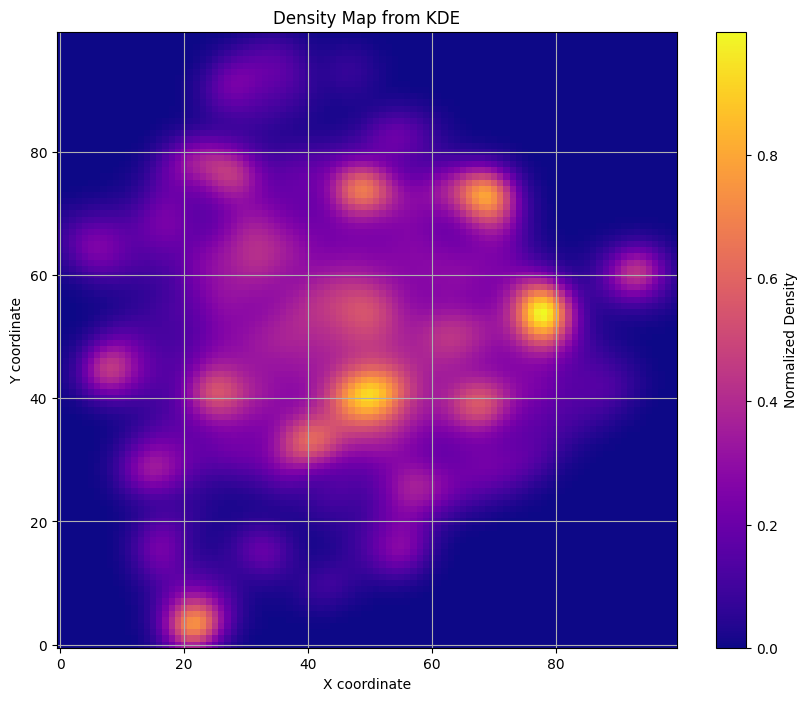

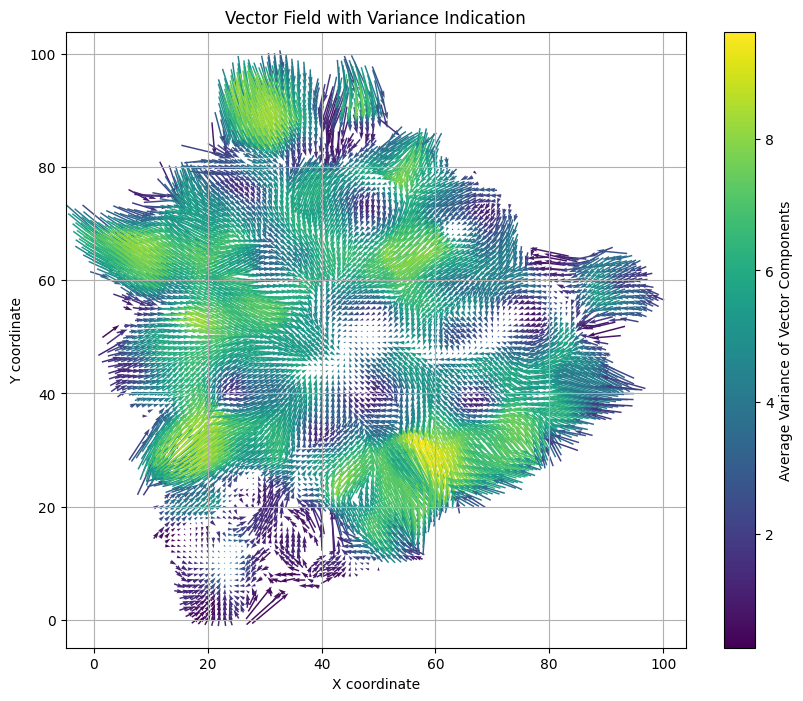

In [9]:
smoothed = process_df(tx, 0, 1)
mu_dx, mu_dy, var_dx, var_dy = dataframe_to_grid(smoothed)
mu_dx, mu_dy, var_dx, var_dy = apply_spatial_smoothing(mu_dx, mu_dy, var_dx, var_dy, 2)
averaged = grid_to_dataframe(mu_dx, mu_dy, var_dx_grid=var_dx, var_dy_grid=var_dy)

# Apply KDE using the trace data
kde_averaged = apply_kde_to_vector_field(averaged, trace, x_col='x', y_col='y')

plot_density_map(kde_averaged)  # Shows the density map
plot_vector_field_with_var(kde_averaged, .7)  # Shows the modified vector field

In [247]:
#kde_averaged.to_csv("/home/jli159/blf/adjusted_vector_field_cc.csv", index=False)

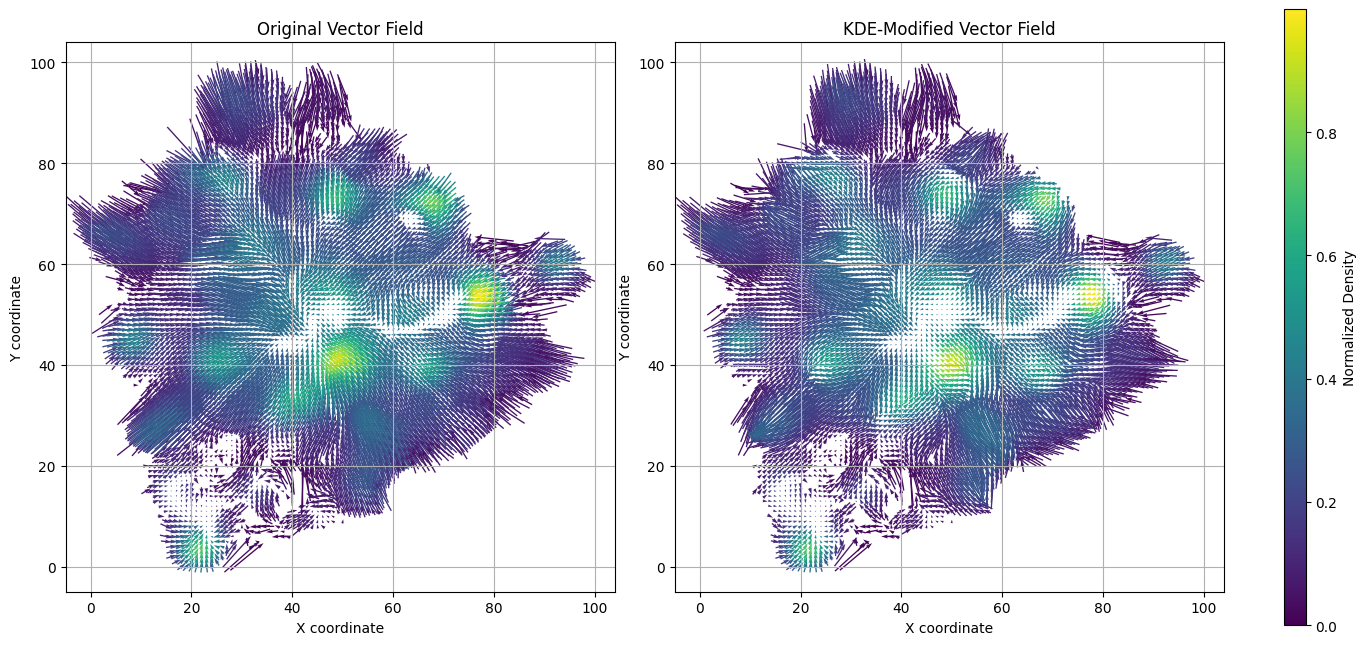

In [18]:
import matplotlib.colors as mcolors
from matplotlib import gridspec

def plot_vector_field_comparison(df_original, df_modified, scale=1):
    all_density = np.concatenate([df_original['norm_density'], df_modified['norm_density']])
    norm = mcolors.Normalize(vmin=all_density.min(), vmax=all_density.max())

    # Set up the grid: 2 columns for plots, 1 narrow column for colorbar
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.16)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    cax = fig.add_subplot(gs[0, 2])  # Dedicated colorbar axis

    Q1 = ax1.quiver(
        df_original['from_x'], df_original['from_y'],
        df_original['mu_dx'] * scale, df_original['mu_dy'] * scale,
        df_original['norm_density'],
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid', norm=norm
    )
    ax1.set_title('Original Vector Field')

    Q2 = ax2.quiver(
        df_modified['from_x'], df_modified['from_y'],
        df_modified['mu_dx'] * scale, df_modified['mu_dy'] * scale,
        df_modified['norm_density'],
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid', norm=norm
    )
    ax2.set_title('KDE-Modified Vector Field')

    for ax in [ax1, ax2]:
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_aspect('equal')
        ax.grid(True)

    cbar = plt.colorbar(Q2, cax=cax)
    cbar.set_label('Normalized Density')

    plt.show()

plot_vector_field_comparison(averaged, kde_averaged, 0.7)

## Attractor Identification

In [19]:
import importlib
import sys
sys.path.append('/home/jli159/blf/')
import vector_field_processor
import trajectory_based_analyzer
import trajectory_analysis
importlib.reload(vector_field_processor)
importlib.reload(trajectory_based_analyzer)
importlib.reload(trajectory_analysis)
from vector_field_processor import DiscreteVectorFieldAnalyzer, ForwardTrajectoryAttractorAnalyzer
from trajectory_based_analyzer import TrajectoryBasedAttractorAnalyzer
from trajectory_analysis import TrajectoryAnalysis

In [20]:
'''
analyzer = TrajectoryAnalysis(averaged)
analyzer.compute_trajectories(
    sample_factor = 1,
    solver = "RK45",
    threshold_speed=0.5,
    enforce_interior_endpoints=True,
    interior_buffer=0.05,
)
'''
analyzer_2 = TrajectoryAnalysis(kde_averaged)
analyzer_2.compute_trajectories(
    sample_factor = 1,
    solver = "RK45",
    threshold_speed=0.5,
    enforce_interior_endpoints=True,
    interior_buffer=0.05,
)

#_,confs = analyzer.identify_attractors_hdbscan(min_samples=30,min_cluster_size=5,confidence_factor=0.005)
_,confs = analyzer_2.identify_attractors_hdbscan(min_samples=30,min_cluster_size=5,confidence_factor=0.005)

#analyzer.assign_basins_to_grid()
analyzer_2.assign_basins_to_grid()

Grid shape: 100 x 100
X range: 0.0 to 99.0
Y range: 0.0 to 99.0


Computing trajectories with RK45:   0%|          | 0/10000 [00:00<?, ?it/s]


Speed statistics:
  Min: 0.000000
  25th percentile: 0.500000
  Median: 0.500000
  Mean: 0.498366
  75th percentile: 0.500000
  Max: 0.865616

Trajectories computed: 5616 successful, 0 failed
Endpoints: 3 near boundary, 2783 below speed threshold
Confidence scores: min = 0.004, max = 0.654, mean = 0.423
HDBSCAN found 10 clusters and 162 noise points (2.9%)
Attractor 0: 3549 points, avg confidence: 0.454
Attractor 1: 1020 points, avg confidence: 0.439
Attractor 2: 369 points, avg confidence: 0.346
Attractor 3: 69 points, avg confidence: 0.289
Attractor 4: 28 points, avg confidence: 0.276
Attractor 5: 81 points, avg confidence: 0.314
Attractor 6: 37 points, avg confidence: 0.270
Attractor 7: 62 points, avg confidence: 0.274
Attractor 8: 32 points, avg confidence: 0.272
Attractor 9: 207 points, avg confidence: 0.271
Basin assignment complete. Grid shape: (100, 100)
Valid data points: 5616
Assigned data points: 5616
  Unassigned: 4384 cells
  Basin 0: 3649 cells (36.5%)
  Basin 1: 1020 ce

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

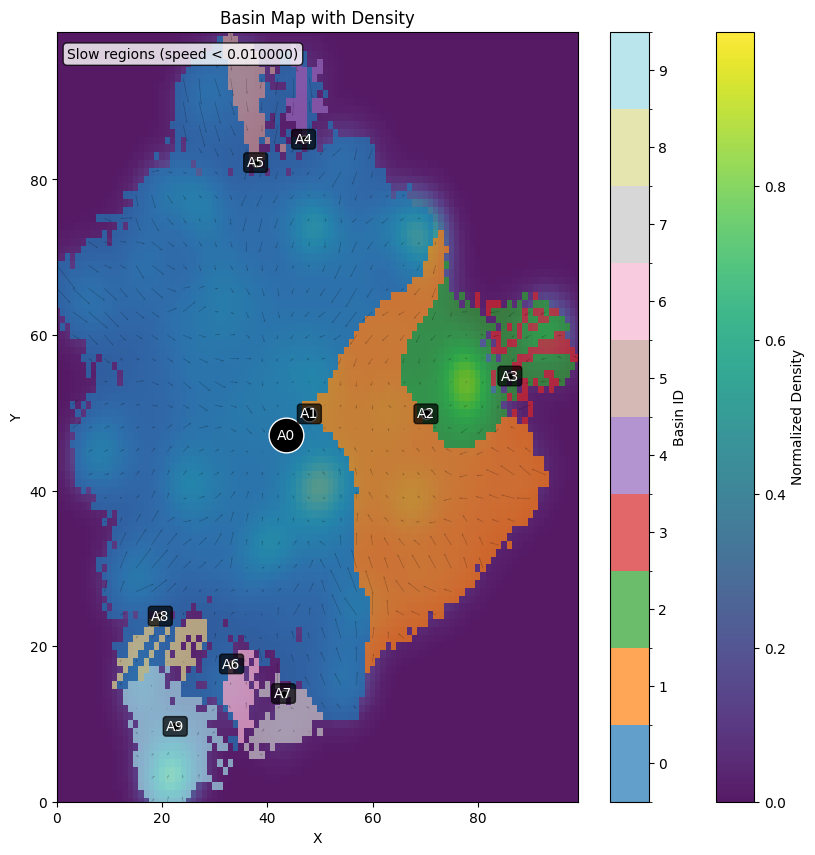

In [21]:
'''
analyzer.plot_basin_heatmap(
    cmap='tab20',
    show_attractors=True,
    show_vector_field=True,
    vector_density=3,
    slow_region_threshold=0.01,
    density_df = averaged
)
'''
analyzer_2.plot_basin_heatmap(
    cmap='tab20',
    show_attractors=True,
    show_vector_field=True,
    vector_density=3,
    slow_region_threshold=0.01,
    density_df = kde_averaged
)

plt.show()

In [22]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator
from scipy.ndimage import distance_transform_edt, binary_erosion

def enrich_user_data(original_df, trajectory_analyzer, x_col='x', y_col='y', 
                     user_id_col='u_id', time_col='dt'):
    """
    Enrich the original user data with insights from the vector field and basin analysis.
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        Original dataframe with user positions in real coordinates (not grid)
    x_col, y_col : str
        Column names for x and y coordinates in the original dataframe
    user_id_col : str
        Column name for user ID in the original dataframe
    time_col : str
        Column name for timestamp in the original dataframe
    trajectory_analyzer : TrajectoryAnalysis object, optional
        If provided, use the existing analyzer object for vector field operations
        
    Returns:
    --------
    pandas.DataFrame
        Enriched original dataframe with additional columns for basin membership,
        vector field properties, and user dynamics metrics
    """

    basin_grid = trajectory_analyzer.basin_grid

    # Create a copy of the original dataframe
    df_enriched = original_df.copy()
    
    # Get min/max of original coordinates for scaling
    x_orig_min, x_orig_max = df_enriched[x_col].min(), df_enriched[x_col].max()
    y_orig_min, y_orig_max = df_enriched[y_col].min(), df_enriched[y_col].max()
    
   
    
    # Get grid coordinates and dimensions
    x_grid = trajectory_analyzer.x_grid
    y_grid = trajectory_analyzer.y_grid
    nx, ny = len(x_grid), len(y_grid)
    
    # Map original coordinates to grid coordinates for interpolation
    x_norm = (df_enriched[x_col] - x_orig_min) / (x_orig_max - x_orig_min)
    y_norm = (df_enriched[y_col] - y_orig_min) / (y_orig_max - y_orig_min)
    df_enriched['x_grid_float'] = x_norm * (nx - 1)
    df_enriched['y_grid_float'] = y_norm * (ny - 1)
    df_enriched['x_grid'] = df_enriched['x_grid_float'].astype(int).clip(0, nx-1)
    df_enriched['y_grid'] = df_enriched['y_grid_float'].astype(int).clip(0, ny-1)
    
    # Get vector field components and create interpolators
    U = trajectory_analyzer.U
    V = trajectory_analyzer.V
    var_U = trajectory_analyzer.var_U
    var_V = trajectory_analyzer.var_V
    magnitude = np.sqrt(U**2 + V**2)
    
    u_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), U, 
                                      bounds_error=False, fill_value=np.nan)
    v_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), V, 
                                      bounds_error=False, fill_value=np.nan)
    var_u_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), var_U, 
                                          bounds_error=False, fill_value=np.nan)
    var_v_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), var_V, 
                                          bounds_error=False, fill_value=np.nan)
    speed_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), magnitude, 
                                          bounds_error=False, fill_value=np.nan)
    
    # Calculate basin metrics (center, average speed, convergence)
    basin_metrics = {}
    basin_centers = {}
    unique_basins = np.unique(basin_grid[basin_grid >= 0])
    
    for basin_id in unique_basins:
        basin_mask = (basin_grid == basin_id)
        y_indices, x_indices = np.where(basin_mask)
        attractor = trajectory_analyzer.attractors[basin_id]
        


        # Use the attractor location
        center_y = attractor['position'][0]
        center_x = attractor['position'][1]
        basin_centers[basin_id] = (center_x, center_y)
        
        # Calculate average speed in basin
        basin_speeds = magnitude[basin_mask]
        avg_speed = np.mean(basin_speeds) if len(basin_speeds) > 0 else np.nan
        
        # Calculate convergence (whether vectors point toward or away from center)
        convergence_sum = 0
        count = 0
        
        for i, j in zip(x_indices, y_indices):
            if i < nx and j < ny and not np.isnan(U[i, j]) and not np.isnan(V[i, j]):
                # Vector from this point to center
                dx_to_center = center_x - i
                dy_to_center = center_y - j
                
                # Vector field at this point
                u_val = U[i, j]
                v_val = V[i, j]
                
                # Calculate dot product (positive if pointing toward center)
                if dx_to_center != 0 or dy_to_center != 0:
                    # Normalize the center vector
                    center_mag = np.sqrt(dx_to_center**2 + dy_to_center**2)
                    dx_to_center /= center_mag
                    dy_to_center /= center_mag
                    
                    # Dot product with vector field
                    dot_product = u_val * dx_to_center + v_val * dy_to_center
                    convergence_sum += dot_product
                    count += 1
        
        # Calculate average convergence (-1 to 1, positive means attraction)
        avg_convergence = convergence_sum / count if count > 0 else 0
        
        # Store metrics for this basin
        basin_metrics[basin_id] = {
            'avg_speed': avg_speed,
            'convergence': avg_convergence,
            'size': np.sum(basin_mask),
            'center': (center_x, center_y)
        }
    
    # Calculate distance to basin edge for each basin
    basin_distance_maps = {}
    
    for basin_id in unique_basins:
        basin_mask = (basin_grid == basin_id)
        basin_edge = basin_mask & ~binary_erosion(basin_mask)
        distance_from_edge = distance_transform_edt(~basin_edge)
        distance_from_edge[~basin_mask] = 0
        basin_distance_maps[basin_id] = distance_from_edge
    
    # Create combined distance map and interpolator
    combined_distance_map = np.zeros_like(basin_grid, dtype=float)
    for basin_id, distance_map in basin_distance_maps.items():
        combined_distance_map[basin_grid == basin_id] = distance_map[basin_grid == basin_id]
    
    distance_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), combined_distance_map, 
                                            bounds_error=False, fill_value=0)
    
    # Create nearest-neighbor interpolator for basin assignment
    points = []
    basins = []
    for i in range(nx):
        for j in range(ny):
            if basin_grid[i, j] >= 0:
                points.append((i, j))
                basins.append(basin_grid[i, j])
    
    if points:
        basin_interp = NearestNDInterpolator(points, basins)
    else:
        basin_interp = lambda coords: np.full(len(coords), -1)
    
    # Apply interpolators to original data points
    coords = np.column_stack((df_enriched['x_grid_float'], df_enriched['y_grid_float']))
    
    # Apply vector field interpolators
    df_enriched['mu_dx'] = u_interp(coords)
    df_enriched['mu_dy'] = v_interp(coords)
    df_enriched['var_dx'] = var_u_interp(coords)
    df_enriched['var_dy'] = var_v_interp(coords)
    df_enriched['speed'] = speed_interp(coords)
    
    # Apply basin assignment and distance interpolators
    basin_assignments = []
    distances_to_edge = []
    
    for i, (x, y) in enumerate(coords):
        basin = basin_interp([[x, y]])[0]
        basin_assignments.append(basin)
        distance = distance_interp([[x, y]])[0]
        distances_to_edge.append(distance)
    
    df_enriched['basin_id'] = basin_assignments
    df_enriched['dist_to_edge'] = distances_to_edge
    
    # Calculate normalized distance to edge
    df_enriched['norm_dist_to_edge'] = np.nan
    
    for basin_id in unique_basins:
        max_dist = np.max(basin_distance_maps[basin_id])
        mask = df_enriched['basin_id'] == basin_id
        if max_dist > 0:
            df_enriched.loc[mask, 'norm_dist_to_edge'] = df_enriched.loc[mask, 'dist_to_edge'] / max_dist
    
    # Calculate distance to basin center
    df_enriched['dist_to_center'] = np.nan
    
    for basin_id, center in basin_centers.items():
        mask = df_enriched['basin_id'] == basin_id
        center_x, center_y = center
        
        x_coords = df_enriched.loc[mask, 'x_grid_float']
        y_coords = df_enriched.loc[mask, 'y_grid_float']
        
        df_enriched.loc[mask, 'dist_to_center'] = np.sqrt(
            (x_coords - center_x)**2 + (y_coords - center_y)**2
        )
    
    # Add basin metrics to dataframe
    df_enriched['basin_avg_speed'] = np.nan
    df_enriched['basin_convergence'] = np.nan
    df_enriched['basin_size'] = np.nan
    
    for basin_id, metrics in basin_metrics.items():
        mask = df_enriched['basin_id'] == basin_id
        df_enriched.loc[mask, 'basin_avg_speed'] = metrics['avg_speed']
        df_enriched.loc[mask, 'basin_convergence'] = metrics['convergence']
        df_enriched.loc[mask, 'basin_size'] = metrics['size']
    
    # Add user movement metrics
    df_enriched = df_enriched.sort_values([user_id_col, time_col])
    
    # Calculate basin changes
    df_enriched['prev_basin'] = df_enriched.groupby(user_id_col)['basin_id'].shift(1)
    df_enriched['basin_change'] = (df_enriched['basin_id'] != df_enriched['prev_basin']).astype(int)
    df_enriched.loc[df_enriched['prev_basin'].isna(), 'basin_change'] = 0

    # TODO:  This is the the first edit
    ############
    ############  Block for transition
    ############
    # Process each user to calculate transition confidence and basin belief
        # Calculate transition confidence (soft boundary)
    df_enriched['transition_confidence'] = 0.0
    df_enriched['basin_belief'] = 0.0
    df_enriched['cumulative_basin_belief'] = 0.0
    
    # Process each user to calculate transition confidence and basin belief
    for user_id, user_data in df_enriched.groupby(user_id_col):
        user_idx = user_data.index
        user_data_sorted = user_data.sort_values(time_col)
        
        # Variables to track belief about which basin the user is in
        current_basin = -1
        basin_belief = 0.0
        transition_confidences = []
        basin_beliefs = []
        time_in_basin = []  # Track how many observations the user has had in current basin
        
        # Parameters for Bayesian updating
        prior_weight = 0.8     # Weight for prior belief
        evidence_weight = 0.2  # Weight for new evidence
        
        # Calculate transition confidence and basin belief
        for i, (idx, row) in enumerate(user_data_sorted.iterrows()):
            basin_id = row['basin_id']
            dist_to_edge = row['norm_dist_to_edge'] if not np.isnan(row['norm_dist_to_edge']) else 0.0
            
            # Handle basin changes
            if basin_id != current_basin and basin_id != -1:
                # Basin transition detected
                
                # Calculate transition confidence - how confident are we this is a real transition?
                # Low when close to basin edge or junction, high when far from edges and junctions
                if 'distance_to_junction' in row and not np.isnan(row['distance_to_junction']):
                    # Include junction distance in the calculation
                    junction_distance = row['norm_distance_to_junction']
                    transition_confidence = 0.5 * dist_to_edge + 0.5 * junction_distance
                else:
                    # Just use distance from edge if junction distance not available
                    transition_confidence = dist_to_edge
                
                # Reset belief for new basin
                basin_belief = dist_to_edge  # Initial belief proportional to distance in
                current_basin = basin_id
                current_time = 1  # Reset time counter
                
            elif basin_id == current_basin:
                # Still in same basin - update belief with Bayesian update
                # Evidence strength based on distance from edge
                evidence = dist_to_edge
                
                # Calculate updated belief with Bayesian-inspired formula
                basin_belief = (prior_weight * basin_belief + 
                               evidence_weight * evidence)
                
                # Transition confidence is high when staying in same basin
                transition_confidence = 0.95  # High confidence when not transitioning
                current_time += 1
                
            else:
                # No assigned basin
                transition_confidence = 0.0
                basin_belief = 0.0
                current_basin = -1
                current_time = 0
            
            # Store results
            transition_confidences.append(transition_confidence)
            basin_beliefs.append(basin_belief)
            time_in_basin.append(current_time)
        
        # Assign values back to the main dataframe
        df_enriched.loc[user_idx, 'transition_confidence'] = transition_confidences
        df_enriched.loc[user_idx, 'basin_belief'] = basin_beliefs
        df_enriched.loc[user_idx, 'time_in_basin'] = time_in_basin



    
    # Calculate position changes
    df_enriched['delta_x'] = df_enriched.groupby(user_id_col)[x_col].diff()
    df_enriched['delta_y'] = df_enriched.groupby(user_id_col)[y_col].diff()
    df_enriched['movement_magnitude'] = np.sqrt(df_enriched['delta_x']**2 + df_enriched['delta_y']**2)
    
    # Calculate time differences
    if pd.api.types.is_datetime64_any_dtype(df_enriched[time_col]):
        df_enriched['time_diff'] = df_enriched.groupby(user_id_col)[time_col].diff().dt.total_seconds()
    else:
        df_enriched['time_diff'] = df_enriched.groupby(user_id_col)[time_col].diff()
    
    # Calculate user speed
    df_enriched['user_speed'] = df_enriched['movement_magnitude'] / df_enriched['time_diff']


        # Calculate entropy of basin appearances for each user
    user_entropies = {}
    for user_id, user_data in df_enriched.groupby(user_id_col):
        # Get basin counts, excluding -1 (non-assigned)
        basin_counts = user_data[user_data['basin_id'] >= 0]['basin_id'].value_counts()
        total_appearances = basin_counts.sum()
        
        if total_appearances > 0:
            # Calculate probabilities
            basin_probs = basin_counts / total_appearances
            # Calculate entropy
            entropy = -np.sum(basin_probs * np.log2(basin_probs))
            user_entropies[user_id] = entropy
        else:
            user_entropies[user_id] = 0.0
    
    df_enriched['user_basin_entropy'] = df_enriched[user_id_col].map(user_entropies)
    
    # Add user stability metrics
    user_basin_changes = df_enriched.groupby(user_id_col)['basin_change'].sum()
    user_total_moves = df_enriched.groupby(user_id_col).size() - 1
    user_change_rate = user_basin_changes / user_total_moves.clip(lower=1)  # Avoid division by zero
    
    df_enriched['user_basin_changes'] = df_enriched[user_id_col].map(user_basin_changes)
    df_enriched['user_total_moves'] = df_enriched[user_id_col].map(user_total_moves)
    df_enriched['user_change_rate'] = df_enriched[user_id_col].map(user_change_rate)
    
    # Calculate user's average speed and movement
    user_avg_speed = df_enriched.groupby(user_id_col)['user_speed'].mean()
    user_avg_movement = df_enriched.groupby(user_id_col)['movement_magnitude'].mean()
    
    df_enriched['user_avg_speed'] = df_enriched[user_id_col].map(user_avg_speed)
    df_enriched['user_avg_movement'] = df_enriched[user_id_col].map(user_avg_movement)
    
    # Calculate a "stability index" for each user (low values = stable, high values = unstable)
    stability_index = (
        (user_change_rate / user_change_rate.mean()) * 0.5 +
        (user_avg_speed / user_avg_speed.mean()) * 0.5
    )
    df_enriched['user_stability_index'] = df_enriched[user_id_col].map(stability_index)
    
    return df_enriched

def analyze_basin_transitions(enriched_df, user_id_col='u_id', time_col='dt'):
    """
    Analyze basin transitions to identify common transition patterns
    and transition probabilities between basins.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Dataframe with basin assignments and user movement data
    user_id_col : str
        Column name for user ID
    time_col : str
        Column name for timestamp
        
    Returns:
    --------
    tuple
        (transition_matrix, transition_counts) 
        Transition probability matrix and raw counts for basin transitions
    """
    # Make sure data is properly sorted
    df = enriched_df.sort_values([user_id_col, time_col])
    
    # Get unique basin IDs, excluding -1 (non-assigned)
    unique_basins = sorted(df['basin_id'].unique())
    if -1 in unique_basins:
        unique_basins.remove(-1)
    
    n_basins = len(unique_basins)
    
    # Initialize transition matrix and counts
    transition_counts = pd.DataFrame(0, index=unique_basins, columns=unique_basins)
    
    # Count transitions for each user
    for user_id, user_data in df.groupby(user_id_col):
        # Get sequence of basins for this user, exclude -1
        basin_seq = user_data['basin_id'].values
        
        # Count transitions
        for i in range(len(basin_seq) - 1):
            # Skip transitions involving -1
            if basin_seq[i] == -1 or basin_seq[i+1] == -1:
                continue
                
            # # Skip self-transitions (staying in same basin)
            # if basin_seq[i] == basin_seq[i+1]:
            #     continue
                
            # Count this transition
            transition_counts.loc[basin_seq[i], basin_seq[i+1]] += 1
    
    # Calculate transition probabilities
    row_sums = transition_counts.sum(axis=1)
    transition_probs = transition_counts.copy()
    
    for i, basin in enumerate(unique_basins):
        if row_sums[basin] > 0:
            transition_probs.loc[basin] = transition_counts.loc[basin] / row_sums[basin]
    
    return transition_probs, transition_counts

def predict_basin_transition(user_data, transition_probs, features=None):
    """
    Predict whether a user is likely to transition to a different basin
    based on their current position and basin transition probabilities.
    
    Parameters:
    -----------
    user_data : pandas.DataFrame
        Data for a single user with enriched basin features
    transition_probs : pandas.DataFrame
        Basin transition probability matrix
    features : list
        List of features to use for prediction
        
    Returns:
    --------
    tuple
        (prediction, confidence) 
        Boolean prediction and confidence score
    """
    from sklearn.ensemble import RandomForestClassifier
    
    if features is None:
        features = [
            'dist_to_edge', 'norm_dist_to_edge', 'speed', 
            'basin_convergence', 'user_change_rate'
        ]
    
    # Get the user's current basin
    current_basin = user_data['basin_id'].iloc[-1]
    
    # If not in a valid basin, can't make prediction
    if current_basin == -1:
        return False, 0.0
    
    # Calculate transition probability based on basin transitions
    if current_basin in transition_probs.index:
        # Get transition probabilities from this basin to others
        probs = transition_probs.loc[current_basin]
        total_trans_prob = probs.sum()  # Sum of all transition probabilities
    else:
        total_trans_prob = 0.0
    
    # Get latest feature values
    latest_data = user_data.iloc[-1]
    
    # Factors that increase transition likelihood
    near_edge = latest_data['norm_dist_to_edge'] < 0.2  # Close to basin edge
    high_speed = latest_data['speed'] > latest_data['basin_avg_speed'] * 1.2  # Moving faster than basin average
    low_convergence = latest_data['basin_convergence'] < 0  # Vectors pointing outward
    
    # Combine factors (simple weighted approach)
    edge_weight = 0.4
    speed_weight = 0.3
    convergence_weight = 0.2
    history_weight = 0.1
    
    transition_score = (
        edge_weight * (1 if near_edge else 0) +
        speed_weight * (1 if high_speed else 0) +
        convergence_weight * (1 if low_convergence else 0) +
        history_weight * min(1.0, latest_data['user_change_rate'] * 2)  # Scale user change rate
    )
    
    # Combine with historical transition probability
    final_score = 0.7 * transition_score + 0.3 * total_trans_prob
    
    # Make prediction (threshold at 0.5)
    prediction = final_score > 0.5
    
    return prediction, final_score

In [23]:
#enriched_df = enrich_user_data(trace,analyzer)
enriched_df2 = enrich_user_data(trace,analyzer_2)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

def combined_cmap(n):
    """Combine multiple colormaps to get more distinct colors"""
    # Use qualitative colormaps
    cmaps = ['tab10', 'Set3', 'Dark2', 'Paired']
    colors = []
    
    for cmap_name in cmaps:
        cmap = plt.cm.get_cmap(cmap_name)
        n_colors = min(10, cmap.N)  # Most have 8-10 colors
        colors.extend([cmap(i) for i in range(n_colors)])
    
    # Take as many as needed
    return ListedColormap(colors[:n])

def plot_transitions_on_basin_map(enriched_df,transition_analyzer=None, 
                                figsize=(12, 10), alpha_basins=0.7, 
                                transition_cmap='hot_r', show_attractors=True, dest=None):
    """
    Visualize basin transitions on top of the basin map with consistent orientation.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    basin_grid : numpy.ndarray
        2D array of basin assignments for each grid cell
    transition_analyzer : TrajectoryAnalysis object, optional
        If provided, attractor information will be used for annotation
    figsize : tuple
        Figure size (width, height)
    alpha_basins : float
        Transparency of the basin colors
    transition_cmap : str
        Colormap for transition heatmap
    show_attractors : bool
        Whether to show attractor markers
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    basin_grid = transition_analyzer.basin_grid

    fig, ax = plt.subplots(figsize=figsize)
    
    # Get grid dimensions
    nx, ny = basin_grid.shape
    
    # Create a mask for areas with no basin
    no_basin_mask = (basin_grid == -1)
    
    # Create a copy of the basin grid for visualization
    vis_grid = basin_grid.copy()
    
    # Count unique basins (excluding -1)
    unique_basins = np.unique(vis_grid[vis_grid >= 0])
    n_basins = len(unique_basins)
    
    # Create coordinate grids - these ensure the proper orientation
    x_coords = np.arange(0, nx)
    y_coords = np.arange(0, ny)
    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
    
    if n_basins > 0:
        basin_cmap = combined_cmap(n_basins)
        
        # Create a normalized colormap
        norm = mcolors.BoundaryNorm(np.arange(-0.5, n_basins + 0.5), basin_cmap.N)
        
        # Replace -1 with masked value for visualization
        vis_grid = np.ma.masked_where(no_basin_mask, vis_grid)
        
        # Plot the basin heatmap
        basin_plot = ax.pcolormesh(X, Y, vis_grid, cmap=basin_cmap, norm=norm, 
                                alpha=alpha_basins, shading='auto')
        
        # Add a colorbar for basins
        cbar_basins = plt.colorbar(basin_plot, ax=ax, location='right', pad=0.01)
        cbar_basins.set_label('Basin ID')
    else:
        print("No basins found to visualize.")
    
    # Now plot transitions on top
    
    # Aggregate transitions by grid cell
    # Create pivot table of grid positions and transitions


    x_col = "x_grid"
    y_col = "y_grid"
    enriched_df=enriched_df.copy()
    enriched_df[["x_prev","y_prev"]] = enriched_df.groupby("u_id")[["x_grid","y_grid"]].shift(1, fill_value=-1)
    if dest != None:
        enriched_df = enriched_df[enriched_df.basin_id == dest]
        x_col = "x_prev"
        y_col = "y_prev"



    pivot_df = pd.pivot_table(
        enriched_df,
        values='basin_change',
        index=x_col,
        columns=y_col,
        aggfunc='sum',
        fill_value=0
    )
    
    # Convert to numpy array with correct orientation
    transition_grid = np.zeros((nx, ny))
    for x in pivot_df.index:
        for y in pivot_df.columns:
            if 0 <= x < nx and 0 <= y < ny:
                transition_grid[x, y] = pivot_df.loc[x, y]
            
    
    # Plot transitions
    if np.max(transition_grid) > 0:
        # Use a different colormap for transitions
        transition_map = ax.pcolormesh(
            X, Y, transition_grid, 
            cmap=transition_cmap, 
            alpha=0.7 * (transition_grid > 0),  # Only show non-zero cells
            shading='auto'
        )
        
        # Add colorbar for transitions
        cbar_trans = plt.colorbar(transition_map, ax=ax, location='left', pad=0.01)
        cbar_trans.set_label('Transition Count')
    
    # Show attractors if requested and available
    if show_attractors and transition_analyzer is not None and hasattr(transition_analyzer, 'attractors'):
        for label, attractor in transition_analyzer.attractors.items():
            pos = attractor['position']
            size = attractor['size']
            
            # Scale marker size by the basin size
            marker_size = 10 + 30 * (size / max(1, max(att['size'] for att in transition_analyzer.attractors.values())))
            
            ax.plot(pos[0], pos[1], 'o', markersize=marker_size, 
                   color='white', markeredgecolor='black', alpha=0.8)
            
            # Add label
            ax.text(pos[0], pos[1], f'A{label}', fontsize=12, 
                   ha='center', va='center', color='black', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Set axis limits and labels
    ax.set_xlim(-0.5, nx - 0.5)
    ax.set_ylim(-0.5, ny - 0.5)
    ax.set_xlabel('Grid X')
    ax.set_ylabel('Grid Y')
    ax.set_title('Basin Map with Transition Overlay')
    
    return fig

def plot_transition_features(enriched_df, feature_x, feature_y='basin_change', 
                           figsize=(10, 8), plot_type='scatter'):
    """
    Plot relationships between transition-related features.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    feature_x : str
        Feature to plot on x-axis
    feature_y : str
        Feature to plot on y-axis, defaults to 'basin_change'
    figsize : tuple
        Figure size (width, height)
    plot_type : str
        Type of plot ('scatter', 'hexbin', 'kde', or 'violin')
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_type == 'scatter':
        # Color points by whether a transition occurred
        colors = np.where(enriched_df['basin_change'] > 0, 'red', 'blue')
        sizes = np.where(enriched_df['basin_change'] > 0, 50, 20)  # Larger points for transitions
        
        # Create a scatter plot
        scatter = ax.scatter(
            enriched_df[feature_x], 
            enriched_df[feature_y], 
            c=colors, 
            s=sizes,
            alpha=0.5
        )
        
        # Add a legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Transition'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='No Transition')
        ]
        ax.legend(handles=legend_elements)
        
    elif plot_type == 'hexbin':
        # Create a hexbin plot
        hb = ax.hexbin(
            enriched_df[feature_x], 
            enriched_df[feature_y], 
            gridsize=30, 
            cmap='viridis', 
            mincnt=1
        )
        plt.colorbar(hb, ax=ax, label='Count')
        
    elif plot_type == 'kde':
        # Create kernel density plots
        transitions = enriched_df[enriched_df['basin_change'] > 0]
        non_transitions = enriched_df[enriched_df['basin_change'] == 0]
        
        sns.kdeplot(
            data=transitions, 
            x=feature_x, 
            ax=ax, 
            color='red', 
            label='Transitions'
        )
        sns.kdeplot(
            data=non_transitions, 
            x=feature_x, 
            ax=ax, 
            color='blue', 
            label='No Transitions'
        )
        ax.legend()
        
    elif plot_type == 'violin':
        # Create a dataframe for the violin plot
        plot_df = enriched_df.copy()
        plot_df['transition'] = np.where(plot_df['basin_change'] > 0, 'Yes', 'No')
        
        # Create a violin plot
        sns.violinplot(
            data=plot_df, 
            x='transition', 
            y=feature_x, 
            ax=ax,
            palette={'Yes': 'red', 'No': 'blue'}
        )
    
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y if plot_type != 'violin' and plot_type != 'kde' else 'Density')
    ax.set_title(f'Relationship between {feature_x} and Transitions')
    
    return fig


/tmp/ipykernel_4086865/1640262773.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


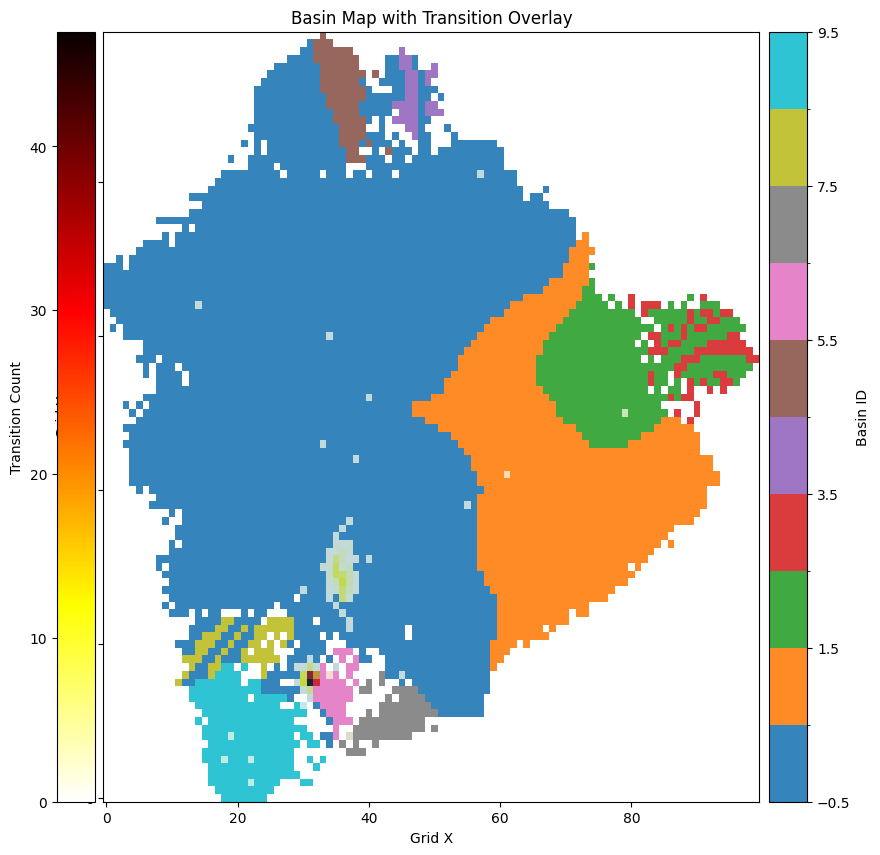

In [28]:
#plot_transitions_on_basin_map(enriched_df,analyzer,alpha_basins=0.9,show_attractors=False,dest=6)
plot_transitions_on_basin_map(enriched_df2,analyzer_2,alpha_basins=0.9,show_attractors=False,dest=6)
plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from scipy import interpolate
from scipy import ndimage
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import datetime

def find_basin_boundaries(basin_grid):
    """
    Find the boundaries of each basin in a grid.
    
    Parameters:
    -----------
    basin_grid : numpy.ndarray
        2D array with basin assignments
        
    Returns:
    --------
    dict
        Dictionary mapping basin_id to boundary coordinates
    """
    from skimage import measure
    
    boundaries = {}
    unique_basins = np.unique(basin_grid)
    
    for basin_id in unique_basins:
        if basin_id == -1:  # Skip unassigned areas
            continue
            
        # Create binary mask for this basin
        basin_mask = (basin_grid == basin_id)
        
        try:
            # Find contours at the 0.5 level (boundary between 0 and 1)
            contours = measure.find_contours(basin_mask.astype(float), 0.5)
            
            if contours:
                # Sort contours by length, keep the longest one(s)
                contours = sorted(contours, key=lambda x: len(x), reverse=True)
                
                # IMPORTANT: Swap coordinates to match the original grid orientation
                # Each contour has (row, col) coordinates, but we need (x, y) = (col, row)
                swapped_contour = np.column_stack((contours[0][:, 1], contours[0][:, 0]))
                boundaries[basin_id] = swapped_contour
                
                # If there are multiple significant contours, process them separately
                if len(contours) > 1:
                    main_contour_length = len(contours[0])
                    for i in range(1, min(len(contours), 3)):  # Limit to top 3 contours
                        if len(contours[i]) > main_contour_length * 0.3:  # More permissive threshold
                            # Swap coordinates and store 
                            swapped_part = np.column_stack((contours[i][:, 1], contours[i][:, 0]))
                            boundaries[f"{basin_id}_part{i}"] = swapped_part
        except Exception as e:
            print(f"Error finding boundary for basin {basin_id}: {str(e)}")
            continue
    
    return boundaries

def smooth_boundary(boundary, smoothing_factor=0.5):
    """
    Apply smoothing to a basin boundary using spline interpolation.
    
    Parameters:
    -----------
    boundary : numpy.ndarray
        Array of (x, y) coordinates defining the boundary
    smoothing_factor : float
        Controls the smoothness of the spline
        
    Returns:
    --------
    numpy.ndarray
        Smoothed boundary coordinates
    """
    # Need at least 4 points for cubic spline
    if len(boundary) < 4:
        return boundary
    
    try:
        # Non-periodic smoothing approach (more robust)
        # Create a parameter along the boundary
        t = np.arange(len(boundary))
        
        # Check if points are unique - if not, add tiny noise
        if len(np.unique(boundary, axis=0)) < len(boundary):
            boundary += np.random.normal(0, 1e-6, boundary.shape)
        
        # Fit a spline to x and y coordinates separately
        x = boundary[:, 0]
        y = boundary[:, 1]
        
        # Use UnivariateSpline for more robust smoothing
        x_spl = interpolate.UnivariateSpline(t, x, k=3, s=len(x)*smoothing_factor)
        y_spl = interpolate.UnivariateSpline(t, y, k=3, s=len(y)*smoothing_factor)
        
        # Generate more points for a smoother curve
        t_new = np.linspace(0, len(boundary) - 1, 4 * len(boundary))
        smooth_x = x_spl(t_new)
        smooth_y = y_spl(t_new)
        
        smooth_boundary = np.column_stack((smooth_x, smooth_y))
        
        # Close the loop by repeating the first point
        smooth_boundary = np.vstack([smooth_boundary, smooth_boundary[0]])
        
        return smooth_boundary
        
    except Exception as e:
        print(f"Smoothing failed for boundary with {len(boundary)} points. Using original boundary.")
        print(f"Error: {str(e)}")
        return boundary

def find_basin_centers(basin_grid):
    """
    Find the centers of each basin for label placement.
    Uses distance transform to find the point furthest from the boundary.
    
    Parameters:
    -----------
    basin_grid : numpy.ndarray
        2D array with basin assignments
        
    Returns:
    --------
    dict
        Dictionary mapping basin_id to center coordinates (x, y)
    """
    from scipy.ndimage import distance_transform_edt
    
    centers = {}
    unique_basins = np.unique(basin_grid)
    
    for basin_id in unique_basins:
        if basin_id == -1:  # Skip unassigned areas
            continue
            
        # Create binary mask for this basin
        basin_mask = (basin_grid == basin_id)
        
        # Skip very small basins
        if np.sum(basin_mask) < 5:
            continue
            
        # Compute distance transform
        distance = distance_transform_edt(basin_mask)
        
        # Find the coordinates of the maximum distance
        center_idx = np.unravel_index(np.argmax(distance), distance.shape)
        
        # Convert from (row, col) to (x, y) format
        # IMPORTANT: Swap coordinates for consistent orientation
        centers[basin_id] = (center_idx[1], center_idx[0])
    
    return centers

def plot_enhanced_basin_map(enriched_df, transition_analyzer, 
                           figsize=(14, 12), transition_cmap='hot_r',
                           show_attractors=False, dest=None,
                           min_date=None, max_date=None, kde_bins=100,
                           boundary_smoothing=0.5, basin_label_fontsize=10,
                           basin_boundary_color='blue', basin_boundary_width=1.5):
    """
    Create an enhanced visualization with KDE background, smooth basin boundaries,
    and transition overlays with optional date filtering.
    
    Parameters:
    -----------
    enriched_df : pandas.DataFrame
        Enriched dataframe with basin assignments and transition metrics
    transition_analyzer : TrajectoryAnalysis object
        Trajectory analyzer object with basin information
    figsize : tuple
        Figure size (width, height)
    transition_cmap : str
        Colormap for transition heatmap
    show_attractors : bool
        Whether to show attractor markers
    dest : int, optional
        If provided, only show transitions to this destination basin
    min_date : datetime or str, optional
        Minimum date for filtering transitions
    max_date : datetime or str, optional
        Maximum date for filtering transitions
    kde_bins : int
        Number of bins for the KDE
    boundary_smoothing : float
        Controls the smoothness of basin boundaries
    basin_label_fontsize : int
        Font size for basin labels
    basin_boundary_color : str
        Color for basin boundaries
    basin_boundary_width : float
        Line width for basin boundaries
    swap_axes : bool
        If True, swap x and y axes for all elements (helps fix orientation issues)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object for further customization
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get basin grid from transition_analyzer
    basin_grid = transition_analyzer.basin_grid
    
    # Get grid dimensions
    nrows, ncols = basin_grid.shape
    
    # Create KDE of all data points as background
    # Ensure x_grid_float and y_grid_float are available
    if 'x_grid_float' in enriched_df.columns and 'y_grid_float' in enriched_df.columns:
        # Create a grayscale KDE - using Greys_r for lighter in higher density areas
        kde_data = enriched_df[['x_grid_float', 'y_grid_float']].dropna()
        
        # Handle axis swapping if needed
        x_var = 'y_grid_float'#if swap_axes else 'x_grid_float'
        y_var = 'x_grid_float' #if swap_axes else 'y_grid_float'
        
        # Use Seaborn's kdeplot for a nicer KDE with inverted colormap
        sns.kdeplot(
            data=kde_data,
            x=x_var, y=y_var,
            fill=True, cmap='Greys_r',  # Using _r suffix for reversed colormap
            levels=15, thresh=0.05,
            ax=ax, alpha=0.7,
            bw_adjust=0.8
        )
    else:
        print("Warning: x_grid_float or y_grid_float columns not found. Skipping KDE background.")
    
    # Find basin boundaries
    boundaries = find_basin_boundaries(basin_grid)
    
    # Find basin centers for labeling
    centers = find_basin_centers(basin_grid)
    
    # Plot smooth basin boundaries
    for basin_id, boundary in boundaries.items():
        try:
            # Smooth the boundary
            smooth_boundary_coords = smooth_boundary(boundary, smoothing_factor=boundary_smoothing)
            
            # Plot the smoothed boundary
            label = None
            if isinstance(basin_id, str) and "_part" in basin_id:
                # This is a secondary contour, use the same color but no label
                base_id = basin_id.split("_part")[0]
                ax.plot(smooth_boundary_coords[:, 0], smooth_boundary_coords[:, 1], 
                       color=basin_boundary_color, linewidth=basin_boundary_width, alpha=0.8)
            else:
                # This is a primary contour, add label if it's the first one
                if basin_id == next(iter([k for k in boundaries.keys() if not isinstance(k, str) or "_part" not in k]), None):
                    label = "Basin Boundaries"
                ax.plot(smooth_boundary_coords[:, 0], smooth_boundary_coords[:, 1], 
                       color=basin_boundary_color, linewidth=basin_boundary_width, alpha=0.8,
                       label=label)
        except Exception as e:
            print(f"Error plotting boundary for basin {basin_id}: {str(e)}")
        
        # Add basin label at center
        if basin_id in centers:
            center_x, center_y = centers[basin_id]
            ax.text(center_x, center_y, f"{basin_id}", 
                   ha='center', va='center', fontsize=basin_label_fontsize,
                   fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, 
                                              boxstyle='round,pad=0.3'))
    
    # Filter transitions by date if requested
    filtered_df = enriched_df.copy()
    if min_date is not None or max_date is not None:
        if 'dt' in filtered_df.columns:
            # Convert min_date and max_date to datetime if they're strings
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            if isinstance(max_date, str):
                max_date = pd.to_datetime(max_date)
            
            # Apply date filters
            if min_date is not None:
                filtered_df = filtered_df[filtered_df['dt'] >= min_date]
            if max_date is not None:
                filtered_df = filtered_df[filtered_df['dt'] <= max_date]
                
            print(f"Filtered transitions from {len(enriched_df)} to {len(filtered_df)} rows.")
        else:
            print("Warning: 'dt' column not found. Cannot filter by date.")
    
    # Prepare for transition plotting
    x_col = "x_grid"
    y_col = "y_grid"
    filtered_df = filtered_df.copy()
    filtered_df[["x_prev", "y_prev"]] = filtered_df.groupby("u_id")[["x_grid", "y_grid"]].shift(1, fill_value=-1)
    
    # Filter to specific destination basin if requested
    if dest is not None:
        filtered_df = filtered_df[filtered_df.basin_id == dest]
        x_col = "x_prev"
        y_col = "y_prev"
        title_suffix = f" (Transitions to Basin {dest})"
    else:
        title_suffix = " (All Transitions)"
    
    # Create transition heatmap
    try:
        pivot_df = pd.pivot_table(
            filtered_df[filtered_df[x_col] >= 0][filtered_df[y_col] >= 0],  # Pre-filter negative values
            values='basin_change',
            index=x_col,
            columns=y_col,
            aggfunc='sum',
            fill_value=0
        )
        
        # Convert to numpy array for heatmap
        transition_grid = np.zeros((nrows, ncols))
        for x in pivot_df.index:
            for y in pivot_df.columns:
                try:
                    #if 0 <= int(x) < nx and 0 <= int(y) < ny:
                    transition_grid[int(y), int(x)] = pivot_df.loc[x, y]
                except (IndexError, ValueError):
                    # Skip any problematic indices
                    continue
    except Exception as e:
        print(f"Error creating transition heatmap: {str(e)}")
        transition_grid = np.zeros((nx, ny))
    
    # Plot transitions
    if np.max(transition_grid) > 0:
        # Create coordinate grids for proper orientation
        x_coords = np.arange(0, ncols)
        y_coords = np.arange(0, nrows)
        
        # if swap_axes:
        #     # Swap X and Y grid and transition grid for display
        #     X, Y = np.meshgrid(y_coords, x_coords,indexing="xy")  # Note the order swap
        #     transition_grid_plot = transition_grid.T  # Transpose the grid
        # else:
        X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
        transition_grid_plot = transition_grid
        
        # Use a different colormap for transitions
        transition_map = ax.pcolormesh(
            X, Y, transition_grid_plot, 
            cmap=transition_cmap, 
            alpha=0.7 * (transition_grid_plot > 0),  # Only show non-zero cells
            shading='auto'
        )
        
        # Add colorbar for transitions
        cbar_trans = plt.colorbar(transition_map, ax=ax, location='right', pad=0.01)
        cbar_trans.set_label('Transition Count')
    
    # Show attractors if requested and available
    if show_attractors and hasattr(transition_analyzer, 'attractors'):
        for label, attractor in transition_analyzer.attractors.items():
            pos = attractor['position']
            size = attractor['size']
            
            # Apply coordinate swapping if needed
            # if swap_axes:
            #     pos = (pos[1], pos[0])
            
            # Scale marker size by the basin size
            marker_size = 10 + 30 * (size / max(1, max(att['size'] for att in transition_analyzer.attractors.values())))
            
            ax.plot(pos[0], pos[1], 'o', markersize=marker_size, 
                   color='red', markeredgecolor='black', alpha=0.8)
            
            # Add label
            x = dict(boxstyle='round,pad=0.2', facecolor='red', alpha='0.7')
            ax.text(pos[0], pos[1], f'A{label}', fontsize=12,ha='center', va='center', color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7)) 
                #    ha='center', va='center', color='white', fontweight='bold',
                #    bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.7'))
    
    # Set axis limits and labels
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(-0.5, nrows - 0.5)
    
    
    ax.set_xlabel('Grid X')
    ax.set_ylabel('Grid Y')

    # Add title with date range if applicable
    title = "Basin Map with KDE Background"
    if min_date is not None or max_date is not None:
        date_range = ""
        if min_date is not None:
            min_date_str = min_date.strftime('%Y-%m-%d') if hasattr(min_date, 'strftime') else str(min_date)
            date_range += f"From {min_date_str} "
        if max_date is not None:
            max_date_str = max_date.strftime('%Y-%m-%d') if hasattr(max_date, 'strftime') else str(max_date)
            date_range += f"To {max_date_str}"
        title += f"\n{date_range}"
    
    title += title_suffix
    ax.set_title(title)
    
    # Add legend for basin boundaries
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:1], ["Basin Boundaries"], loc='upper left')
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    return fig

# Example usage:
# fig = plot_enhanced_basin_map(
#     enriched_df, 
#     transition_analyzer,
#     dest=5,  # Show transitions to basin 5
#     min_date='2023-01-01',
#     max_date='2023-03-31'
# )
# plt.show()

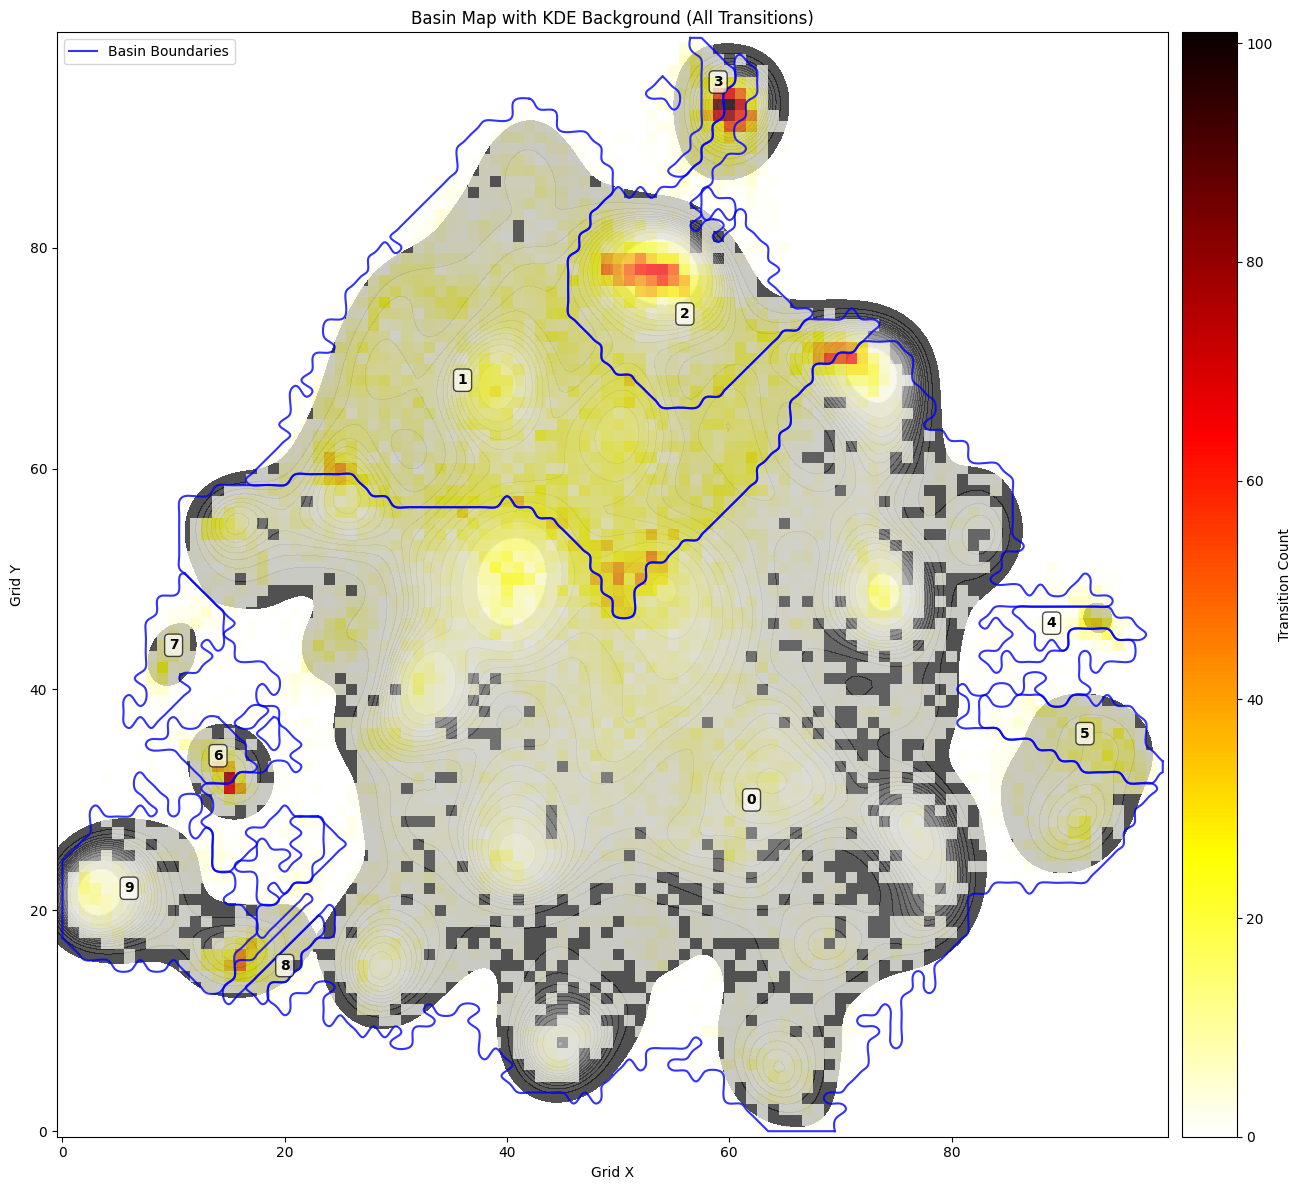

In [32]:
#plot_enhanced_basin_map(enriched_df,analyzer,boundary_smoothing=0)
plot_enhanced_basin_map(enriched_df2,analyzer_2,boundary_smoothing=0)
plt.show()

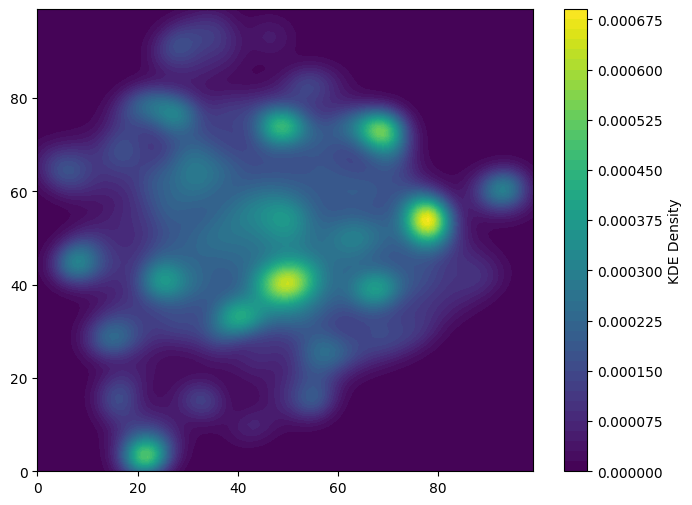

In [34]:
import matplotlib.pyplot as plt
from  scipy.stats import gaussian_kde

df = enriched_df2

fig, ax = plt.subplots(figsize=(8, 6))
x_data = df['x_grid_float'].values
y_data = df['y_grid_float'].values
data = np.vstack([x_data, y_data])

# Compute the KDE using a Gaussian kernel
kde = gaussian_kde(data)

# Define the grid over the raw data range
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the KDE on the grid and reshape
kde_values = kde(grid_coords).reshape(xx.shape)

# Create a filled contour plot of the KDE density
contour = ax.contourf(xx, yy,kde_values, levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label='KDE Density')
plt.show()

/tmp/ipykernel_4086865/1640262773.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


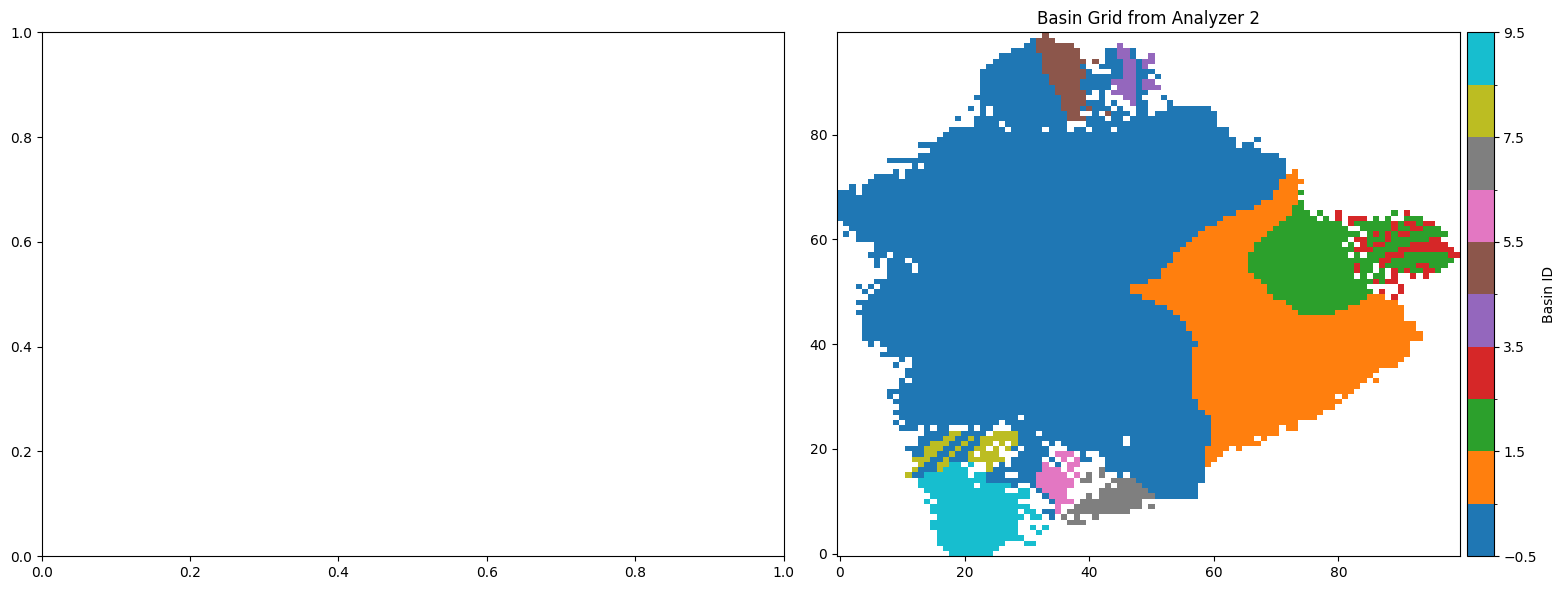

In [35]:
# Extract basin grids
#basin_grid_1 = analyzer.basin_grid
basin_grid_2 = analyzer_2.basin_grid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get grid dimensions (assuming both are the same shape)
nx, ny = basin_grid_2.shape
x_coords = np.arange(0, nx)
y_coords = np.arange(0, ny)
X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')

# Plotting function for each basin grid
def plot_basin(ax, basin_grid, title):
    no_basin_mask = (basin_grid == -1)
    vis_grid = basin_grid.copy()

    unique_basins = np.unique(vis_grid[vis_grid >= 0])
    n_basins = len(unique_basins)

    if n_basins > 0:
        basin_cmap = combined_cmap(n_basins)
        norm = mcolors.BoundaryNorm(np.arange(-0.5, n_basins + 0.5), basin_cmap.N)
        vis_grid = np.ma.masked_where(no_basin_mask, vis_grid)

        basin_plot = ax.pcolormesh(X, Y, vis_grid, cmap=basin_cmap, norm=norm, shading='auto')
        cbar = plt.colorbar(basin_plot, ax=ax, location='right', pad=0.01)
        cbar.set_label('Basin ID')
        ax.set_title(title)

# Plot each analyzer's basin grid
#plot_basin(ax1, basin_grid_1, "Basin Grid from Analyzer 1")
plot_basin(ax2, basin_grid_2, "Basin Grid from Analyzer 2")

plt.tight_layout()
plt.show()


Running KDE-guided basin processing...
Computing KDEs...
Filling unlabelled cells...
Filled 2 unlabelled cells using KDE
Adjusting basin boundaries...
Iteration 1: KDE voting adjusted 219 boundary cells
Iteration 2: KDE voting adjusted 60 boundary cells
Total KDE voting adjustments: 279 boundary cells
Ensuring basin continuity...
Applying mode filter...


/tmp/ipykernel_4086865/2424054739.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  if   n<=10: return plt.cm.get_cmap('tab10', n)


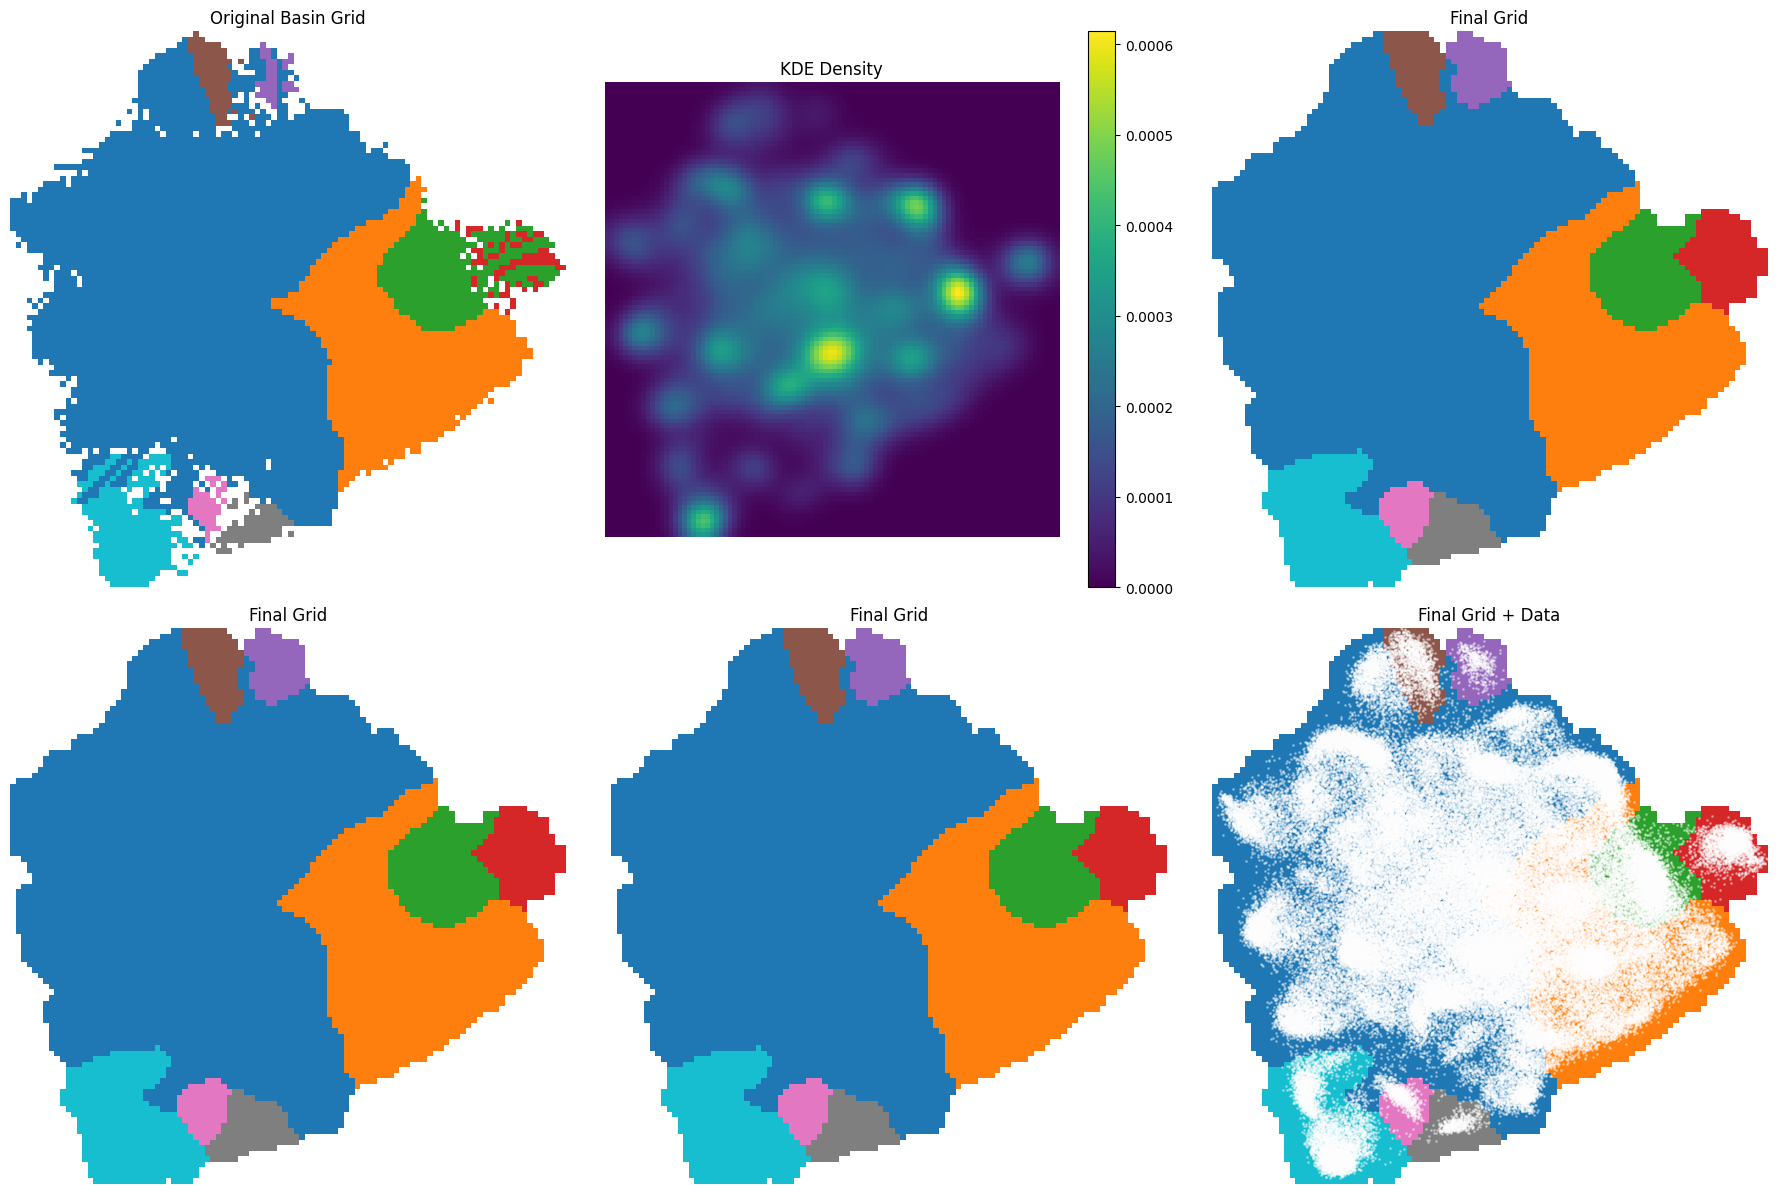

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from skimage.morphology import skeletonize
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# ─────────────────────────────────────────── helpers ──
def extract_boundary_mask(grid):
    nrows, ncols = grid.shape
    pad  = np.pad(grid, 1, constant_values=-2)
    mask = np.zeros_like(grid, bool)
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        mask |= (grid != pad[1+dx:1+dx+nrows, 1+dy:1+dy+ncols]) & (grid>-1)
    return mask

def majority_vote(vals, special=-1):
    vals = vals[~np.isnan(vals)]
    if len(vals)==0: return np.nan
    vals = vals[vals!=special]
    if len(vals)==0: return special
    uniq, cnt = np.unique(vals, return_counts=True)
    return uniq[np.argmax(cnt)]

def mode_filter(grid, k=3, special=-1):
    return ndimage.generic_filter(
        grid, lambda v: majority_vote(v, special), size=k, mode='reflect')

def make_cmap(n):
    if   n<=10: return plt.cm.get_cmap('tab10', n)
    elif n<=20: return plt.cm.get_cmap('tab20', n)
    hsv = [(i/n, 0.8, 0.8) for i in range(n)]
    rgb = [mcolors.hsv_to_rgb(h) for h in hsv]
    return LinearSegmentedColormap.from_list('basins', rgb, N=n)

# ───────────────────────────────────── KDE utilities ──
def compute_kdes(grid, df, 
                 global_smooth=1, 
                 basin_smooth=1,
                 min_points=10,
                 fallback_sigma=2):
    """
    Compute KDE for all data points and for each basin.
    
    Parameters:
    -----------
    grid : 2D array
        The basin grid
    df : DataFrame
        DataFrame containing x_grid_float and y_grid_float columns
    global_smooth : float, optional
        The smoothing factor for the overall KDE
    basin_smooth : float, optional
        The smoothing factor for individual basin KDEs
    min_points : int, optional
        Minimum number of points required in a basin to compute KDE
    fallback_sigma : float, optional
        Sigma value for Gaussian filter when KDE fails
        
    Returns:
    --------
    all_kde : 2D array
        The overall KDE
    basin_kdes : dict
        Dictionary mapping basin IDs to their KDEs
    """
    nrows, ncols   = grid.shape
    xs, ys         = np.arange(ncols)+0.5, np.arange(nrows)+0.5
    xx, yy         = np.meshgrid(xs, ys, indexing='xy')
    eval_pts       = np.vstack([xx.ravel(), yy.ravel()])
    pts            = np.vstack([df['x_grid_float'].values,
                                df['y_grid_float'].values])

    # overall KDE - keeping original bandwidth behavior
    try:
        kde_all = gaussian_kde(pts)  # Using default bandwidth
        all_kde = kde_all(eval_pts).reshape(nrows, ncols)
    except Exception as e:
        print(f"Warning: Failed to compute overall KDE: {e}")
        print(f"Falling back to histogram + Gaussian filter with sigma={fallback_sigma}")
        all_kde = np.zeros((nrows, ncols))
        for x, y in zip(*pts.astype(int)):
            if 0 <= y < nrows and 0 <= x < ncols:
                all_kde[y, x] += 1
        all_kde = gaussian_filter(all_kde, fallback_sigma)
    
    if global_smooth > 0:
        all_kde = gaussian_filter(all_kde, global_smooth)

    # per-basin KDEs - keeping original bandwidth behavior
    basin_kdes = {}
    for b in np.unique(grid[grid >= 0]):
        mask = (grid[pts[1].astype(int), pts[0].astype(int)] == b)
        if mask.sum() < min_points:
            print(f"Basin {b} has only {mask.sum()} points, less than min_points={min_points}")
            basin_kdes[b] = np.zeros_like(all_kde)
            continue
        try:
            kde_b = gaussian_kde(pts[:, mask])  # Using default bandwidth
            dens_b = kde_b(eval_pts).reshape(nrows, ncols)
            if basin_smooth > 0:
                dens_b = gaussian_filter(dens_b, basin_smooth)
        except Exception as e:
            print(f"Warning: Failed to compute KDE for basin {b}: {e}")
            print(f"Falling back to histogram + Gaussian filter with sigma={fallback_sigma}")
            dens_b = np.zeros_like(all_kde)
            for x, y in zip(*pts[:, mask].astype(int)):
                if 0 <= y < nrows and 0 <= x < ncols:
                    dens_b[y, x] += 1
            dens_b = gaussian_filter(dens_b, fallback_sigma)
        basin_kdes[b] = dens_b
    return all_kde, basin_kdes

def fill_unlabelled(grid, all_kde, basin_kdes, 
                    thresh=0.05, 
                    min_confidence=0.2,
                    max_density_ratio=0.75,
                    fill_isolated=True):
    """
    Fill unlabelled cells based on KDE values.
    
    Parameters:
    -----------
    grid : 2D array
        The basin grid with -1 for unlabelled cells
    all_kde : 2D array
        The overall KDE
    basin_kdes : dict
        Dictionary mapping basin IDs to their KDEs
    thresh : float, optional
        Threshold relative to max KDE for considering a cell for filling
    min_confidence : float, optional
        Minimum confidence level required to assign a basin
    max_density_ratio : float, optional
        Maximum ratio between top two basin densities for assignment
    fill_isolated : bool, optional
        Whether to fill isolated cells surrounded by a single basin
        
    Returns:
    --------
    out : 2D array
        The filled grid
    """
    out = grid.copy()
    
    # First pass: Fill isolated cells surrounded by a single basin
    if fill_isolated:
        for i in range(1, grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                if grid[i, j] == -1:
                    neighbors = [
                        grid[i-1, j], grid[i+1, j],
                        grid[i, j-1], grid[i, j+1]
                    ]
                    neighbors = [n for n in neighbors if n >= 0]
                    if neighbors and all(n == neighbors[0] for n in neighbors):
                        out[i, j] = neighbors[0]
    
    # Second pass: KDE-based filling
    mask = (out == -1) & (all_kde >= thresh * all_kde.max())
    filled_count = 0
    
    for i, j in zip(*np.where(mask)):
        # Get all basin densities at this point
        densities = {b: d[i, j] / (d.max() or 1) for b, d in basin_kdes.items()}
        
        # Sort by density
        sorted_densities = sorted(densities.items(), key=lambda x: x[1], reverse=True)
        
        # Check if we have enough basins to evaluate
        if len(sorted_densities) < 2:
            if sorted_densities and sorted_densities[0][1] >= min_confidence:
                out[i, j] = sorted_densities[0][0]
                filled_count += 1
            continue
            
        best_basin, best_density = sorted_densities[0]
        second_basin, second_density = sorted_densities[1]
        
        # Only assign if best density meets minimum confidence
        if best_density < min_confidence:
            continue
            
        # Only assign if the best density is significantly better than the second
        if second_density > 0 and best_density / second_density < 1 / max_density_ratio:
            continue
            
        out[i, j] = best_basin
        filled_count += 1
        
    print(f"Filled {filled_count} unlabelled cells using KDE")
    return out

def kde_voting(grid, basin_kdes, 
               window_size=4, 
               confidence_factor=1.5,
               min_votes=1,
               weight_by_distance=True,
               max_iterations=1):
    """
    Adjust basin boundaries using KDE voting.
    
    Parameters:
    -----------
    grid : 2D array
        The basin grid
    basin_kdes : dict
        Dictionary mapping basin IDs to their KDEs
    window_size : int, optional
        Size of the voting window
    confidence_factor : float, optional
        Factor by which winning basin's KDE must exceed current basin's KDE
    min_votes : int, optional
        Minimum number of votes required for reassignment
    weight_by_distance : bool, optional
        Whether to weight votes by distance from center
    max_iterations : int, optional
        Maximum number of iterations for voting
        
    Returns:
    --------
    out : 2D array
        The adjusted grid
    """
    if window_size % 2 == 0:
        half = window_size // 2
    else:
        half = (window_size - 1) // 2
        
    nrows, ncols = grid.shape
    norm_kde = {b: d / (d.max() or 1) for b, d in basin_kdes.items()}
    out = grid.copy()
    
    # Create distance weights if needed
    if weight_by_distance:
        y, x = np.ogrid[-half:half+1, -half:half+1]
        dist = np.sqrt(x*x + y*y)
        weights = 1 / (1 + dist)
    else:
        weights = np.ones((window_size, window_size))
    
    total_changes = 0
    
    for iteration in range(max_iterations):
        bmask = extract_boundary_mask(out)
        changes = 0
        
        for i, j in zip(*np.where(bmask)):
            cur = out[i, j]
            if cur < 0:
                continue
                
            votes = {}
            vote_count = {}
            
            # Collect votes from neighborhood
            for ii in range(max(0, i-half), min(nrows, i+half+1)):
                for jj in range(max(0, j-half), min(ncols, j+half+1)):
                    lab = out[ii, jj]
                    if lab < 0:
                        continue
                        
                    # Weight by distance and KDE
                    w = weights[ii-i+half, jj-j+half]
                    votes[lab] = votes.get(lab, 0) + w * norm_kde[lab][i, j]
                    vote_count[lab] = vote_count.get(lab, 0) + 1
            
            if not votes:
                continue
                
            # Find winner with sufficient votes
            candidates = [(b, v) for b, v in votes.items() 
                         if vote_count.get(b, 0) >= min_votes]
            
            if not candidates:
                continue
                
            win, win_val = max(candidates, key=lambda x: x[1])
            
            # Only change if winner is significantly better
            if (win != cur and 
                norm_kde[win][i, j] > confidence_factor * norm_kde[cur][i, j]):
                out[i, j] = win
                changes += 1
        
        total_changes += changes
        print(f"Iteration {iteration+1}: KDE voting adjusted {changes} boundary cells")
        
        # Stop if no changes
        if changes == 0:
            break
    
    print(f"Total KDE voting adjustments: {total_changes} boundary cells")
    return out

def ensure_continuity(grid, 
                      min_region_size=None,
                      keep_largest=True,
                      fill_holes=True,
                      hole_size_threshold=10):
    """
    Ensure basins are continuous by removing or relabeling disconnected regions.
    
    Parameters:
    -----------
    grid : 2D array
        The basin grid
    min_region_size : int, optional
        Minimum size for a region to be kept (if None, use 5% of largest)
    keep_largest : bool, optional
        Whether to keep only the largest region for each basin
    fill_holes : bool, optional
        Whether to fill holes in basins
    hole_size_threshold : int, optional
        Maximum size of holes to fill
        
    Returns:
    --------
    out : 2D array
        The processed grid with continuous basins
    """
    out = grid.copy()
    
    # Process each basin
    for b in np.unique(grid[grid >= 0]):
        # Label connected components
        lbl, n = ndimage.label(grid == b)
        
        if n <= 1 and not fill_holes:
            continue
        
        areas = np.bincount(lbl.ravel())[1:]
        largest_area = areas.max()
        
        # Determine size threshold
        if min_region_size is None:
            size_threshold = max(1, int(0.05 * largest_area))
        else:
            size_threshold = min_region_size
        
        if keep_largest:
            # Keep only the largest region
            keep = np.argmax(areas) + 1
            out[(lbl != 0) & (lbl != keep)] = -1
        else:
            # Keep regions above threshold
            for i, area in enumerate(areas, 1):
                if area < size_threshold:
                    out[lbl == i] = -1
        
        # Fill holes if requested
        if fill_holes:
            basin_mask = (out == b)
            holes, n_holes = ndimage.label(~basin_mask)
            hole_sizes = np.bincount(holes.ravel())[1:]
            
            # Skip the background (typically the largest "hole")
            if len(hole_sizes) > 0:
                background = np.argmax(hole_sizes) + 1
                for i, size in enumerate(hole_sizes, 1):
                    if i != background and size <= hole_size_threshold:
                        out[holes == i] = b
    
    return out

# ───────────────────────────────────────── main pipeline ──
def process_grid(grid, df, 
                 # KDE computation parameters
                 global_smooth=1,
                 basin_smooth=1,
                 min_points=10,
                 
                 # Fill parameters
                 fill_thresh=0.05,
                 min_confidence=0.2,
                 max_density_ratio=0.75,
                 fill_isolated=True,
                 
                 # Voting parameters
                 voting_window=4,
                 confidence_factor=1.5,
                 min_votes=1,
                 weight_by_distance=True,
                 voting_iterations=1,
                 
                 # Continuity parameters
                 min_region_size=None,
                 keep_largest=True,
                 fill_holes=True,
                 hole_size_threshold=10,
                 
                 # Filtering parameters
                 mode_filter_size=3,
                 
                 # Control flow
                 skip_fill=False,
                 skip_voting=False,
                 skip_continuity=False,
                 skip_filtering=False,
                 debug=True):
    """
    Process a basin grid using KDE-based methods.
    
    Parameters:
    -----------
    grid : 2D array
        The basin grid
    df : DataFrame
        DataFrame containing x_grid_float and y_grid_float columns
    
    KDE computation parameters:
    global_smooth : float, optional
        The smoothing factor for the overall KDE
    basin_smooth : float, optional
        The smoothing factor for individual basin KDEs
    min_points : int, optional
        Minimum number of points required in a basin to compute KDE
        
    Fill parameters:
    fill_thresh : float, optional
        Threshold relative to max KDE for considering a cell for filling
    min_confidence : float, optional
        Minimum confidence level required to assign a basin
    max_density_ratio : float, optional
        Maximum ratio between top two basin densities for assignment
    fill_isolated : bool, optional
        Whether to fill isolated cells surrounded by a single basin
        
    Voting parameters:
    voting_window : int, optional
        Size of the voting window
    confidence_factor : float, optional
        Factor by which winning basin's KDE must exceed current basin's KDE
    min_votes : int, optional
        Minimum number of votes required for reassignment
    weight_by_distance : bool, optional
        Whether to weight votes by distance from center
    voting_iterations : int, optional
        Maximum number of iterations for voting
        
    Continuity parameters:
    min_region_size : int, optional
        Minimum size for a region to be kept
    keep_largest : bool, optional
        Whether to keep only the largest region for each basin
    fill_holes : bool, optional
        Whether to fill holes in basins
    hole_size_threshold : int, optional
        Maximum size of holes to fill
        
    Filtering parameters:
    mode_filter_size : int, optional
        Size of the mode filter window
        
    Control flow:
    skip_fill : bool, optional
        Whether to skip the filling step
    skip_voting : bool, optional
        Whether to skip the voting step
    skip_continuity : bool, optional
        Whether to skip the continuity step
    skip_filtering : bool, optional
        Whether to skip the filtering step
    debug : bool, optional
        Whether to visualize the results
        
    Returns:
    --------
    results : dict
        Dictionary containing all intermediate and final results
    """
    # First, rotate the grid to match the orientation in the visualization
    # This applies the same transformation used in show_grid when rotate=True
    rotated_grid = np.fliplr(np.rot90(grid, -1))
    
    # Compute KDEs
    print("Computing KDEs...")
    all_kde, basin_kdes = compute_kdes(
        rotated_grid, df,
        global_smooth=global_smooth,
        basin_smooth=basin_smooth,
        min_points=min_points
    )
    
    # Initialize processed grid
    processed = rotated_grid.copy()
    
    # Fill unlabelled cells
    if not skip_fill:
        print("Filling unlabelled cells...")
        processed = fill_unlabelled(
            processed, all_kde, basin_kdes,
            thresh=fill_thresh,
            min_confidence=min_confidence,
            max_density_ratio=max_density_ratio,
            fill_isolated=fill_isolated
        )
    
    # Adjust basin boundaries
    if not skip_voting:
        print("Adjusting basin boundaries...")
        processed = kde_voting(
            processed, basin_kdes,
            window_size=voting_window,
            confidence_factor=confidence_factor,
            min_votes=min_votes,
            weight_by_distance=weight_by_distance,
            max_iterations=voting_iterations
        )
    
    # Ensure basin continuity
    if not skip_continuity:
        print("Ensuring basin continuity...")
        processed = ensure_continuity(
            processed,
            min_region_size=min_region_size,
            keep_largest=keep_largest,
            fill_holes=fill_holes,
            hole_size_threshold=hole_size_threshold
        )
    
    # Apply mode filter
    if not skip_filtering:
        print("Applying mode filter...")
        processed = mode_filter(processed, mode_filter_size)
    
    # Collect results
    results = dict(
        original_grid       = grid,  # Keep original unrotated grid for visualization
        all_kde             = all_kde,
        basin_kdes          = basin_kdes,
        filled_grid         = processed if skip_fill else None,
        voted_grid          = processed if skip_voting else None,
        continuous_grid     = processed if skip_continuity else None,
        final_grid          = processed,
        final_boundary_mask = extract_boundary_mask(processed),
        final_skeleton      = skeletonize(extract_boundary_mask(processed)),
    )
    
    if debug:
        _visualise(results, df)
    
    return results

# ─────────────────────────────────── visualisation ──
def _visualise(res, df, show_intermediate=True):
    """
    Visualize the KDE basin processing results.
    
    Parameters:
    -----------
    res : dict
        Dictionary containing processing results
    df : DataFrame
        DataFrame containing data points
    show_intermediate : bool, optional
        Whether to show intermediate processing steps
    """
    nrows, ncols = res['original_grid'].shape
    extent       = [-0.5, ncols-0.5, -0.5, nrows-0.5]
    
    # Determine number of basins for colormap
    n_basins = len(np.unique(res['final_grid'][res['final_grid'] >= 0]))
    cmap     = make_cmap(n_basins)
    norm     = mcolors.BoundaryNorm(np.arange(-0.5, cmap.N-0.5), cmap.N)

    if show_intermediate:
        fig, ax = plt.subplots(2, 3, figsize=(18, 12))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax = np.array([[ax[0]], [ax[1]]])

    # helper to show a basin grid
    def show_grid(a, g, title, rotate=False):
        if rotate:
            g = np.fliplr(np.rot90(g, -1))
            ext = [-0.5, g.shape[1]-0.5, -0.5, g.shape[0]-0.5]
        else:
            ext = extent
        a.imshow(np.ma.masked_where(g == -1, g),
                 cmap=cmap, norm=norm, origin='lower', extent=ext)
        a.set_title(title); a.axis('off')

    if show_intermediate:
        # 1 ─ original (fixed orientation only here)
        show_grid(ax[0, 0], res['original_grid'], 'Original Basin Grid', rotate=True)

        # 2 ─ KDE density
        im = ax[0, 1].imshow(res['all_kde'], origin='lower', extent=extent, cmap='viridis')
        ax[0, 1].set_title('KDE Density'); ax[0, 1].axis('off')
        plt.colorbar(im, ax=ax[0, 1])

        # 3 ─ KDE-filled
        if res['filled_grid'] is not None:
            show_grid(ax[0, 2], res['filled_grid'], 'KDE-Filled Grid')
        else:
            show_grid(ax[0, 2], res['final_grid'], 'Final Grid')

        # 4 ─ KDE adjusted
        if res['voted_grid'] is not None:
            show_grid(ax[1, 0], res['voted_grid'], 'KDE-Adjusted Grid')
        else:
            show_grid(ax[1, 0], res['final_grid'], 'Final Grid')

        # 5 ─ final grid
        show_grid(ax[1, 1], res['final_grid'], 'Final Grid')

        # 6 ─ final grid + data points
        show_grid(ax[1, 2], res['final_grid'], 'Final Grid + Data')
        ax[1, 2].scatter(df['x_grid_float'] + 0.5,
                         df['y_grid_float'] + 0.5,
                         s=1, c='white', alpha=.35)
    else:
        # Just show original and final
        show_grid(ax[0, 0], res['original_grid'], 'Original Basin Grid', rotate=True)
        show_grid(ax[1, 0], res['final_grid'], 'Final Grid + Data')
        ax[1, 0].scatter(df['x_grid_float'] + 0.5,
                         df['y_grid_float'] + 0.5,
                         s=1, c='white', alpha=.35)
    
    plt.tight_layout()
    plt.show()

# ─────────────────────────── wrapper to run everything ──
def run_kde_basin_processing(basin_grid, df, 
                             # Common presets
                             preset=None,
                             # Pass through all parameters to process_grid
                             **kwargs):
    """
    Run KDE-guided basin processing with flexible parameters.
    
    Parameters:
    -----------
    basin_grid : 2D array
        The basin grid
    df : DataFrame
        DataFrame containing x_grid_float and y_grid_float columns
    preset : str, optional
        Preset configuration ('conservative', 'aggressive', 'balanced')
    **kwargs : dict
        Additional parameters passed to process_grid
        
    Returns:
    --------
    results : dict
        Dictionary containing all intermediate and final results
    """
    print('Running KDE-guided basin processing...')
    
    # Apply presets if specified
    if preset is not None:
        if preset == 'conservative':
            # Conservative settings - minimal changes
            params = {
                'global_smooth': 0.9,
                'basin_smooth': 0.9,
                'fill_thresh': 0.1,     # Higher threshold
                'min_confidence': 0.4,   # Require higher confidence
                'max_density_ratio': 0.6, # Require clearer winner
                'confidence_factor': 2.0, # Require stronger evidence for voting
                'voting_iterations': 1,
                'keep_largest': True,
                'fill_holes': False,
                'mode_filter_size': 3
            }
        elif preset == 'aggressive':
            # Aggressive settings - more changes
            params = {
                'global_smooth': 1.5,
                'basin_smooth': 1.5,
                'fill_thresh': 0.01,   # Lower threshold
                'min_confidence': 0.1,  # Accept lower confidence
                'max_density_ratio': 0.9, # Accept closer winners
                'confidence_factor': 1.1, # Less evidence needed for voting
                'voting_iterations': 3,
                'keep_largest': False,
                'fill_holes': True,
                'hole_size_threshold': 20,
                'mode_filter_size': 5
            }
        elif preset == 'balanced':
            # Balanced settings
            params = {
                'global_smooth': 1.2,
                'basin_smooth': 1.2,
                'fill_thresh': 0.05,
                'min_confidence': 0.2,
                'max_density_ratio': 0.75,
                'confidence_factor': 1.5,
                'voting_iterations': 2,
                'keep_largest': True,
                'fill_holes': True,
                'hole_size_threshold': 10,
                'mode_filter_size': 3
            }
        else:
            raise ValueError(f"Unknown preset: {preset}")
        
        # Override preset with explicit kwargs
        params.update(kwargs)
    else:
        params = kwargs
    
    return process_grid(basin_grid, df, **params)


results = run_kde_basin_processing(
    basin_grid_2, df,
    preset='balanced',          
    debug=True                      # Show visualization
)

fixed_2 = results['final_grid']
boundary_mask_2 = results['final_boundary_mask']
skeleton_2 = results['final_skeleton']

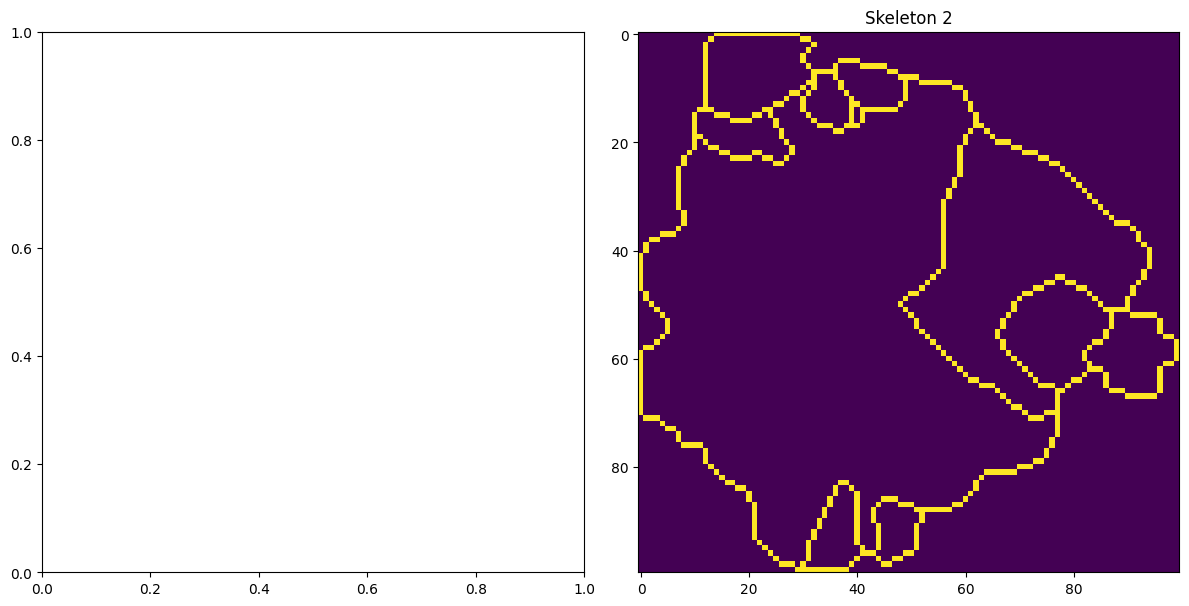

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#ax[0].imshow(skeleton)
#ax[0].set_title("Skeleton 1")
ax[1].imshow(skeleton_2)
ax[1].set_title("Skeleton 2")
plt.tight_layout()
plt.show()

In [241]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

def assign_refined_basins_to_df(df, final_grid):
    """
    Assigns refined basin labels from the processed grid back to the original DataFrame.
    For points not assigned to any basin (-1), assigns the label of the nearest valid basin point.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    result_df['final_basin'] = -1  # Default to -1 (no basin)

    # Get the grid shape
    nrows, ncols = final_grid.shape

    # Assign basin labels from the grid
    for idx, row in result_df.iterrows():
        x = int(row['x_grid_float'])
        y = int(row['y_grid_float'])
        if 0 <= x < ncols and 0 <= y < nrows:
            label = final_grid[y, x]
            result_df.at[idx, 'final_basin'] = label

    # --- Assign -1 basin points to the nearest valid basin ---
    # 1. Get valid and invalid basin points
    valid_mask = result_df['final_basin'] != -1
    invalid_mask = ~valid_mask

    # If there are any -1 points, assign them the nearest valid basin
    if invalid_mask.any() and valid_mask.any():
        valid_points = result_df.loc[valid_mask, ['x', 'y']].values
        valid_basins = result_df.loc[valid_mask, 'final_basin'].values
        invalid_points = result_df.loc[invalid_mask, ['x', 'y']].values

        # Use a KDTree for fast nearest-neighbor search
        tree = cKDTree(valid_points)
        dist, idxs = tree.query(invalid_points, k=1)
        # Assign nearest basin
        result_df.loc[invalid_mask, 'final_basin'] = valid_basins[idxs]

    return result_df

# Usage example (assume enriched_df2 and fixed_2 are already defined):
enriched_df2 = assign_refined_basins_to_df(enriched_df2, fixed_2)

# Display the first few rows to verify
print(enriched_df2[['x', 'y', 'final_basin']].head())

basin_counts = enriched_df2['final_basin'].value_counts().sort_index()
print("\nPoints per final basin:")
print(basin_counts)


               x         y  final_basin
50404  22.076456 -4.707787            0
0      21.852156 -5.451804            0
50405  22.517124 -4.323751            0
50406  23.640362 -2.489461            0
50407  23.296371 -4.816743            0

Points per final basin:
0    109160
1     30253
2     11320
3      3397
4       514
5      1468
6      1110
7       659
8      1350
9      7055
Name: final_basin, dtype: int64


In [242]:
enriched_df2.head()

x         y                        dt   u_id  clust_labels  \
50404  22.076456 -4.707787 2020-09-21 17:07:48+00:00  12428           1.0   
0      21.852156 -5.451804 2020-10-05 13:11:46+00:00  12428           1.0   
50405  22.517124 -4.323751 2020-10-06 01:30:51+00:00  12428           1.0   
50406  23.640362 -2.489461 2020-10-06 01:36:42+00:00  12428           1.0   
50407  23.296371 -4.816743 2020-07-26 15:00:07+00:00  29283           1.0   

       botscore  basin  x_grid_float  y_grid_float  x_grid  ...  time_diff  \
50404      0.07      2     32.528362     33.719102      32  ...        NaN   
0          0.07      2     30.485704     27.849163      30  ...  1195438.0   
50405      0.07      2     36.541438     36.748964      36  ...    44345.0   
50406      0.07      2     46.770538     51.220641      46  ...      351.0   
50407      0.22      2     43.637887     32.859492      43  ...        NaN   

         user_speed  user_basin_entropy  user_basin_changes  user_total_moves  \
50404           NaN            0.811278                   1                 3   
0      6.500476e-07            0.811278                   1                 3   
50405  2.952893e-05            0.811278                   1                 3   
50406  6.127861e-03            0.811278                   1                 3   
50407           NaN            0.365099                   3                35   

       user_change_rate  user_avg_speed  user_avg_movement  \
50404          0.333333        0.002053           1.412477   
0              0.333333        0.002053           1.412477   
50405          0.333333        0.002053           1.412477   
50406          0.333333        0.002053           1.412477   
50407          0.085714        0.000021           0.484394   

       user_stability_index  final_basin  
50404              0.981079            0  
0                  0.981079            0  
50405              0.981079            0  
50406              0.981079            0  
50407              0.178746            0  

[5 rows x 42 columns]

/tmp/ipykernel_4086865/3485600808.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap('tab10', n)


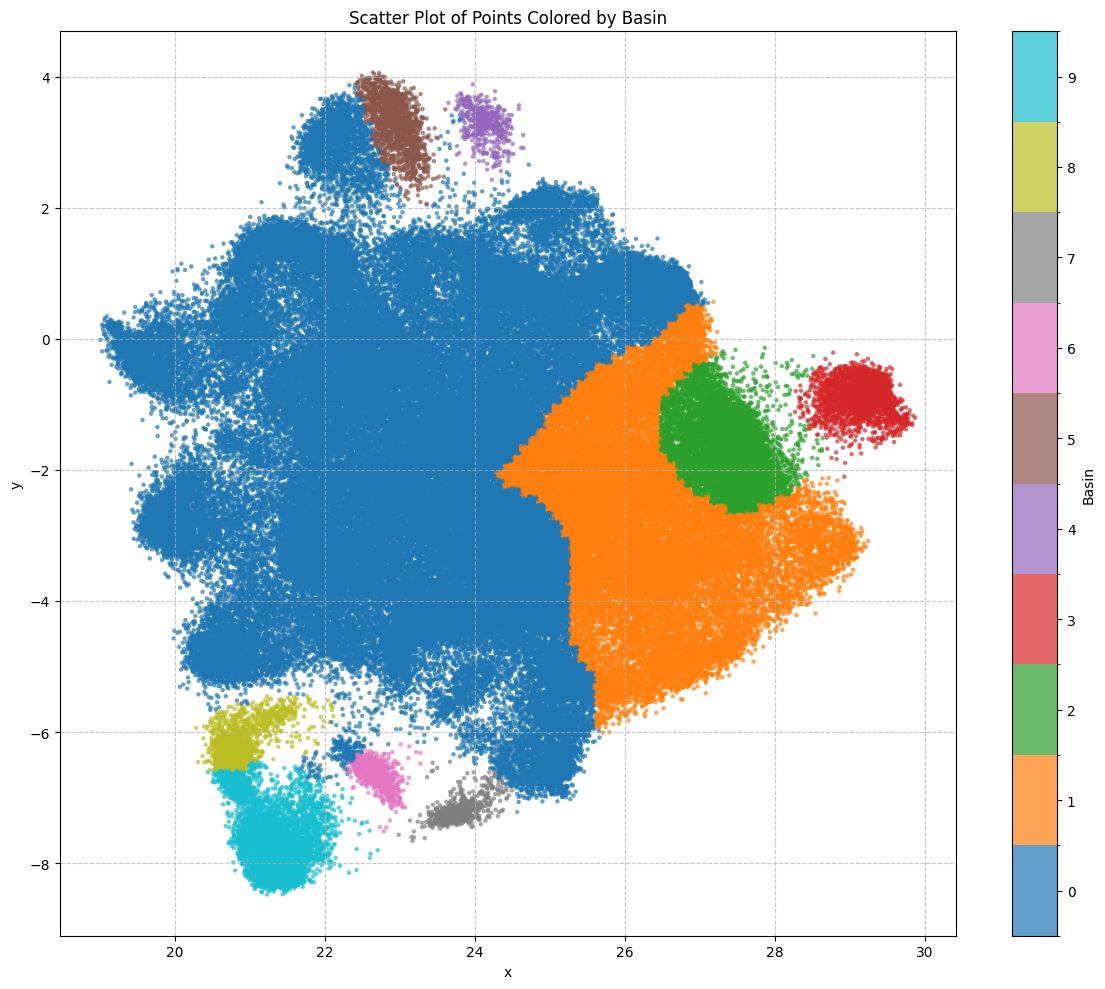

<module 'matplotlib.pyplot' from '/home/jli159/DEV/spacey.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [243]:
def create_basin_scatter_plot(df, x_col='x', y_col='y', basin_col='final_basin'):
    """
    Create a scatter plot of points colored by basin.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the data (assumed to be enriched_df2)
    x_col : str
        Column name for x-coordinates
    y_col : str
        Column name for y-coordinates
    basin_col : str
        Column name for basin labels
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from matplotlib.colors import LinearSegmentedColormap
    
    # Get unique basin values for color mapping
    unique_basins = np.unique(df[basin_col].dropna())
    n_basins = len(unique_basins)
    
    # Use the same color mapping function from the previous code
    def make_cmap(n):
        if n <= 10: 
            return plt.cm.get_cmap('tab10', n)
        elif n <= 20: 
            return plt.cm.get_cmap('tab20', n)
        hsv = [(i/n, 0.8, 0.8) for i in range(n)]
        rgb = [mcolors.hsv_to_rgb(h) for h in hsv]
        return LinearSegmentedColormap.from_list('basins', rgb, N=n)
    
    # Create colormap and normalization
    cmap = make_cmap(n_basins)
    norm = mcolors.BoundaryNorm(np.arange(-0.5, n_basins+0.5), n_basins)
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    
    # Create scatter plot with colored points by basin
    sc = plt.scatter(
        df[x_col] + 0.5,  # Add 0.5 for grid cell center alignment
        df[y_col] + 0.5,  # Add 0.5 for grid cell center alignment
        c=df[basin_col], 
        cmap=cmap,
        norm=norm,
        s=10,             # Point size
        alpha=0.7,        # Transparency
        edgecolors='none'
    )
    
    # Add colorbar
    cbar = plt.colorbar(sc, ticks=range(n_basins))
    cbar.set_label('Basin')
    
    # Set labels and title
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.title('Scatter Plot of Points Colored by Basin')
    
    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return plt

create_basin_scatter_plot(enriched_df2)

In [245]:
enriched_df2.to_csv("/home/jli159/blf/trace_cc_with_final_basins.csv", index=False)

<Axes: xlabel='X', ylabel='Y'>

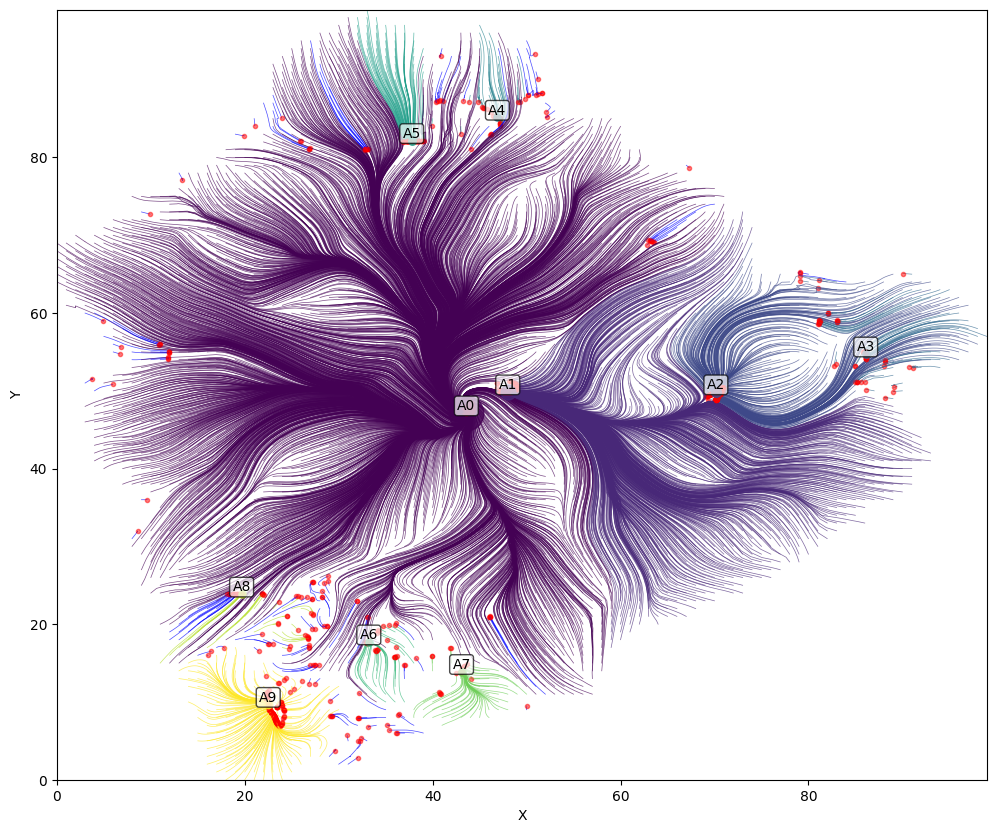

In [144]:
#analyzer.plot_trajectories(sample_factor=1,show_endpoints=True,color_by_basin=True)
analyzer_2.plot_trajectories(sample_factor=1,show_endpoints=True,color_by_basin=True)